# LOCALIZED EXPLORATORY DATA ANALYSIS

This exploratory analysis was done with the purpose of understanding the behavior of the meteorological variables with the Dengue variables in various municipalities. It is worth noting that the files read in this notebook have already been preprocessed. This notebook is designed to receive any municipality and run the analysis for the set of municipalities with few modifications to the code.

In [464]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set_style("ticks")
import pandas as pd
from datetime import datetime
import glob
import os
from modules import  data_management as dm
from modules import  preprocessing as prep
from modules import visualization as viz
from modules import ts_utils
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
plt.rcParams.update({'font.size': 12})
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading municipality metadata

In [286]:
path_data = "./local/data/prepared_per_city/"
df_cities = dm.read_cities_file()
df_cities

department   municipality   code                  dl_folder  \
0            Antioquia       Medellín  05001              MEDELLIN_DATA   
1            Magdalena    Santa Marta  47001           SANTA_MARTA_DATA   
2            Santander    Bucaramanga  68001           BUCARAMANGA_DATA   
3            Atlántico   Barranquilla  08001  SOLEDAD_BARRANQUILLA_DATA   
4            Atlántico        Soledad  08758  SOLEDAD_BARRANQUILLA_DATA   
5   Norte de Santander         Cúcuta  54001                CUCUTA_DATA   
6      Valle del Cauca           Cali  76001                  CALI_DATA   
7              Caquetá  Villavicencio  50001         VILLAVICENCIO_DATA   
8               Tolima         Ibagué  73001                IBAGUE_DATA   
9              Córdoba       Montería  23001              MONTERIA_DATA   
10           Antioquia          Bello  05088              MEDELLIN_DATA   

   starting_date                   stations_temp  \
0     2011/05/20  [27015330, 27015310, 27015300]   
1     2008/06/28                      [15015120]   
2     2014/12/11                      [23195230]   
3     2013/05/03            [29045190, 29004520]   
4     2007/01/01                              []   
5     2006-09-03            [16015110, 16015501]   
6     2006/11/24            [26085170, 26055120]   
7     2007/03/18            [35035100, 35025110]   
8     2007/01/01                              []   
9     2007/01/01                              []   
10    2007/01/01                              []   

                      stations_hum                             stations_prec  \
0   [27015330, 27015310, 27015300]            [27015330, 27015290, 27011270]   
1                       [15015120]            [15015050, 15010501, 15015120]   
2                       [23195230]                                [23195230]   
3                       [29045190]            [29045120, 29040450, 29045190]   
4                               []                                        []   
5             [16015110, 16015501]            [16015110, 16015010, 16015501]   
6             [26085170, 26055120]            [26055120, 26080310, 26085170]   
7             [35035100, 35025110]  [35030380, 35030370, 35030100, 35035020]   
8                               []                                        []   
9                               []                                        []   
10                              []                                        []   

   stations_rad    range_temp    range_hum  
0            []  [15.5, 37.5]  [15, 99.99]  
1            []    [17.5, 40]  [40, 99.99]  
2            []      [17, 40]  [30, 99.99]  
3            []      [22, 45]  [45, 99.99]  
4            []            []           []  
5            []    [17.5, 45]  [30, 99.99]  
6            []    [16.5, 45]  [30, 99.99]  
7            []      [20, 45]  [35, 99.99]  
8            []            []           []  
9            []      [22, 45]  [45, 99.99]  
10           []      [22, 45]  [45, 99.99]

In [287]:
figsize = (15,10)
dpi = 75
dates_range = (pd.to_datetime("2007/01/01"),pd.to_datetime("2021/01/31"))
indexes = [3, 1, 0, 5, 6, 7]
dic_municipios = {}
params_to_get = ["department","municipality","dl_folder","code", "starting_date"]
path_data = f'local/data/prepared_per_city/'

for index in indexes:
    params_city = {param:df_cities.loc[index,param] for param in params_to_get}
    name = params_city["municipality"]
    dic_municipios[name] = params_city
    df_municipio = pd.read_csv(path_data+f"{prep.municipality_name_to_filename(params_city['municipality'])}_consolidado_{params_city['starting_date'][0:4]}_2020.csv", index_col = 0, parse_dates= True, dtype = {'COD_MUNICIPIO':str})
    df_municipio["DENGUE_PER_100K"] = (100000/df_municipio["POBLACION"])*df_municipio["DENGUE"]
    df_municipio["CITY"] = name
    df_municipio = df_municipio[['COD_DPTO', 'COD_MUNICIPIO', 'CITY', 'ANO', 'SEMANA','POBLACION',
       'PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
       'TEMPERATURE_AMIN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_AMIN',
       'TEMPERATURE_MEAN', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3',
       'SST4', 'SST3.4', 'TNI', 'CAR', 'NTA', 'DENGUE', 'DENGUE_PER_100K']]
    dic_municipios[name]["df"] = df_municipio

In [288]:
municipios = list(dic_municipios.keys())
municipios

['Barranquilla', 'Santa Marta', 'Medellín', 'Cúcuta', 'Cali', 'Villavicencio']

# TEMPERATURE DATA ANALYSIS

Temperature is mainly described by the weekly mean temperature variable, but there are also maximum and minimum values for both variables which are interesting to review. 

## Weekly temperature plot

First, we look at the mean temperatures over the years. The area around the mean represents the maximum and minimum temperature value for each week. That is, the range of values that temperature took for each city on every week.



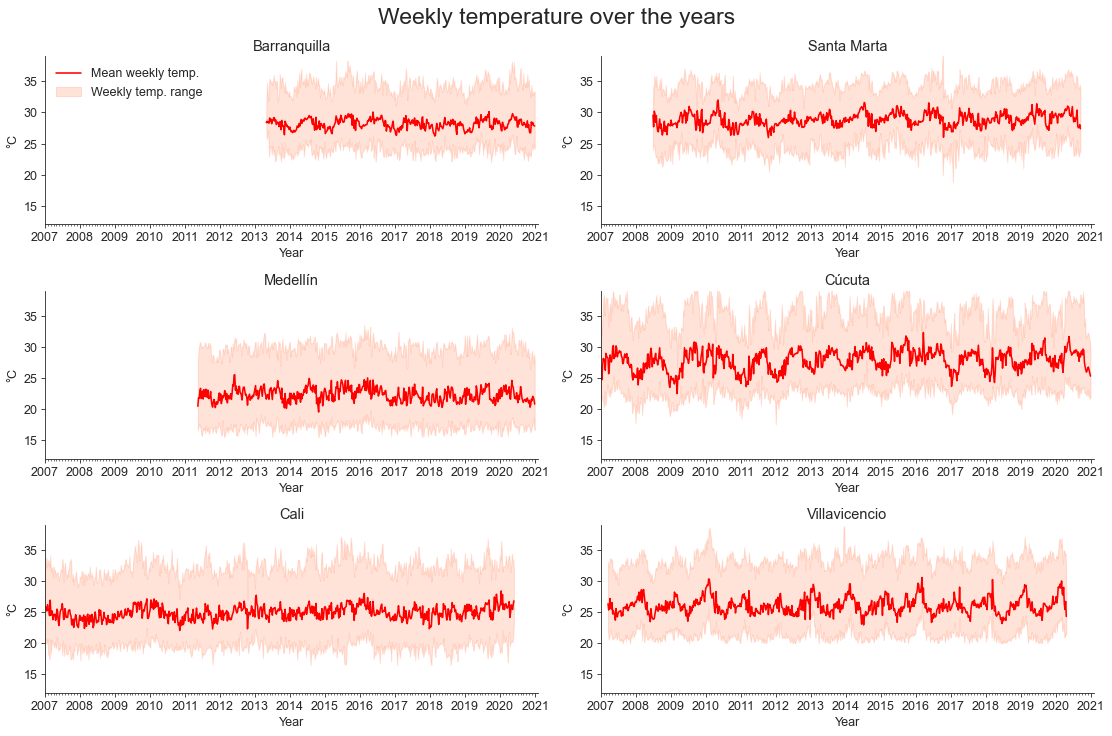

In [295]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["TEMPERATURE_MEAN"], df["TEMPERATURE_AMIN"], df["TEMPERATURE_AMAX"]]
    labels_array = ["Mean weekly temp.", "Weekly temp. range"]
    colors = ["red","orangered"]
    title = n
    ylabel = "°C"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (12, 39), fulldates = True)
    plt.suptitle("Weekly temperature over the years", fontsize="22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

## Temperature trend plots

Here we visualize thre trend of temperature over the years for all 6 cities. For all cities, there were peaks in temperature for years 2010 (if data was available) and 2015-2016.

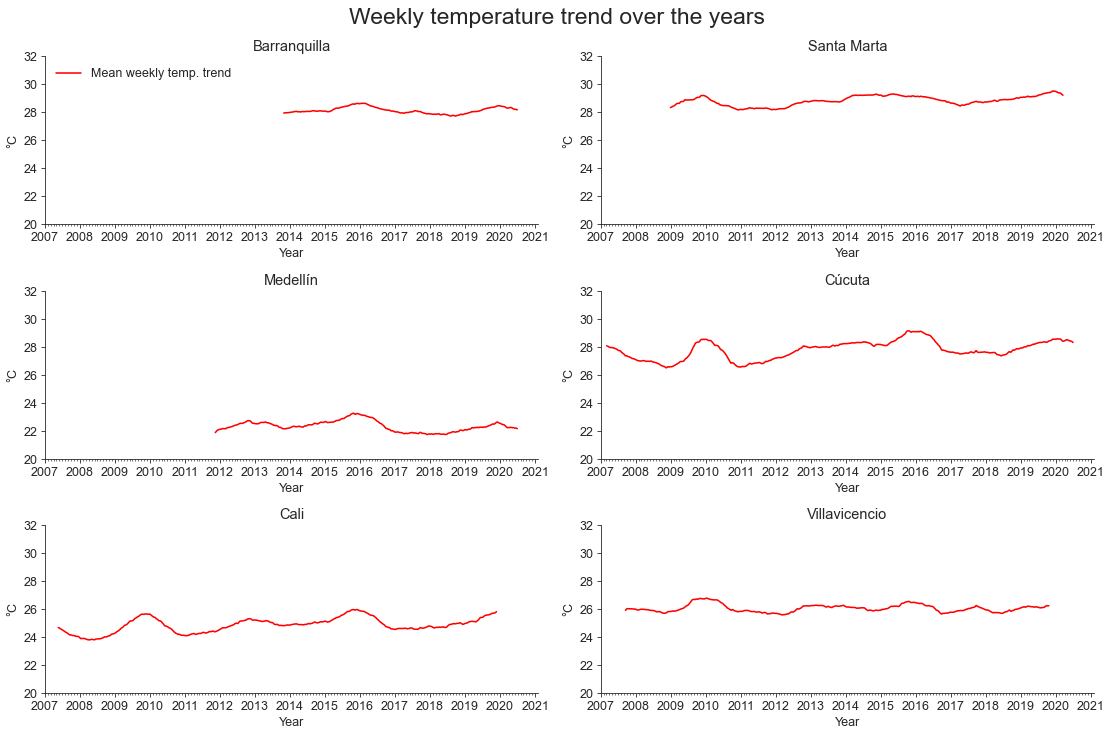

In [296]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    decomp = seasonal_decompose(df["TEMPERATURE_MEAN"].dropna())
    x_array = [df["TEMPERATURE_MEAN"].dropna().index]
    y_array = [decomp.trend]
    labels_array = ["Mean weekly temp. trend"]
    colors = ["red"]
    title = n
    ylabel = "°C"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (20, 32), fulldates = True, area_plot = False)
    plt.suptitle("Weekly temperature trend over the years", fontsize = "22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

## Temperatures per month

Now we look at the boxplots of the mean temperature per month for each city. Here we can observe the fluctuations in the mean temperature over the year for each city. Furthermore, we can observe which cities have had more stable temperatures for each month over the years, as represented by the size of each box and the length of the whiskers.

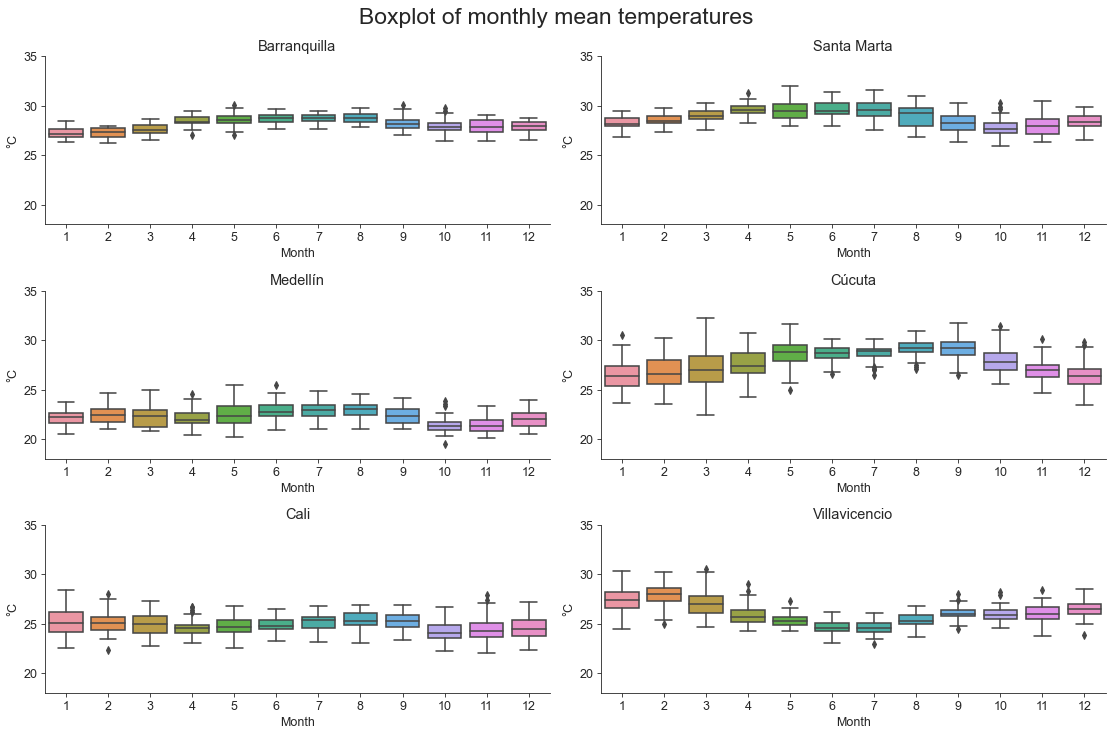

In [294]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]    
    x_array = [df.index.month]
    y_array = [df["TEMPERATURE_MEAN"]]
    colors = None
    title = n
    ylabel = "°C"
    xlabel = "Month"
    viz.plot_monthly_boxplot(ax[i], x_array, y_array, title, xlabel, ylabel, (18, 35))
    plt.suptitle("Boxplot of monthly mean temperatures", fontsize = "22")

fig.tight_layout()
plt.show()

# RELATIVE HUMIDITY DATA ANALYSIS

The analysis of the relative humidity data is very similar to the one done to the temperature.

## Weekly relative humidity plot

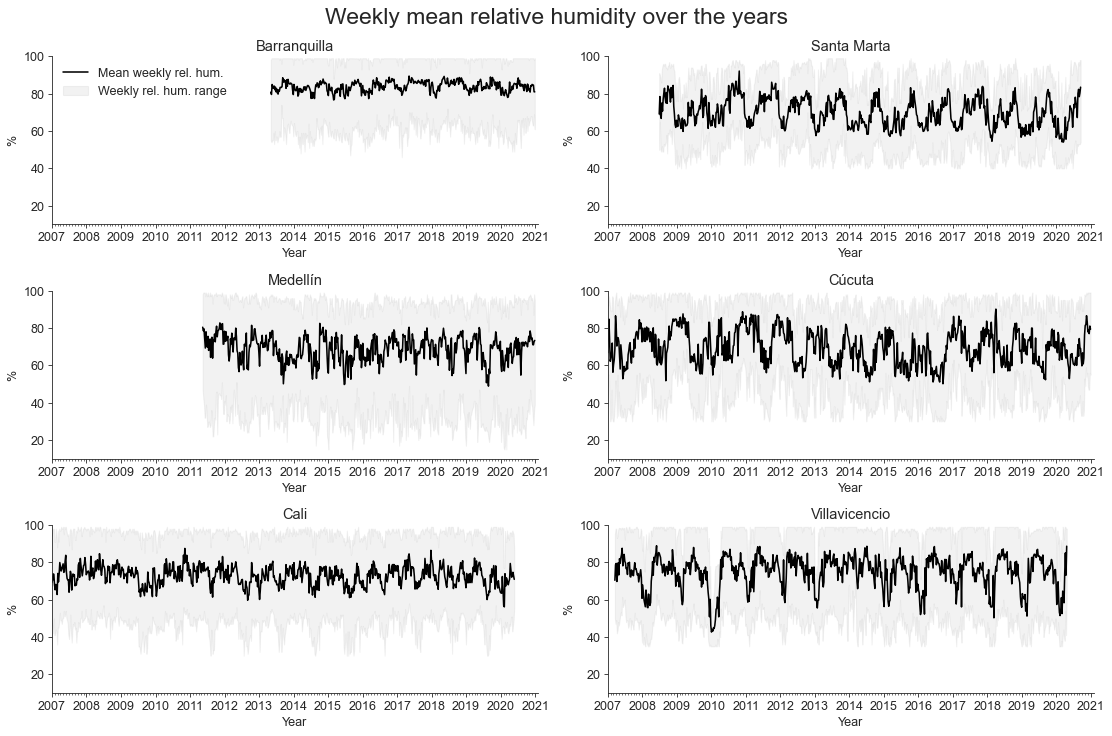

In [382]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["REL_HUMIDITY_MEAN"], df["REL_HUMIDITY_AMIN"],df["REL_HUMIDITY_AMAX"] ]
    labels_array = ["Mean weekly rel. hum.", "Weekly rel. hum. range"]
    title = n
    colors = ["black","darkgray"]
    ylabel = "%"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (10, 100), fulldates = True)
    plt.suptitle("Weekly mean relative humidity over the years", fontsize="22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

## Weekly relative humidity trend

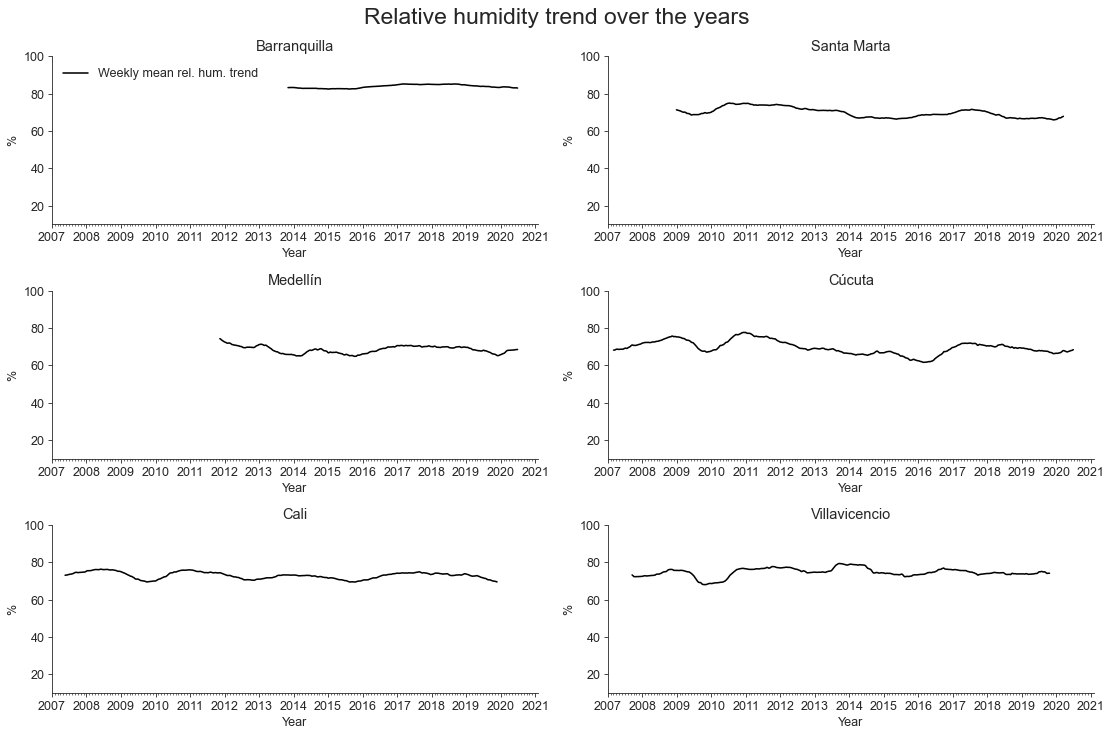

In [383]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    decomp = seasonal_decompose(df["REL_HUMIDITY_MEAN"].dropna())
    x_array = [df["REL_HUMIDITY_MEAN"].dropna().index]
    y_array = [decomp.trend]
    labels_array = ["Weekly mean rel. hum. trend"]
    colors = ["black"]
    title = n
    ylabel = "%"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (10, 100), fulldates = True, area_plot = False)
    plt.suptitle("Relative humidity trend over the years", fontsize = "22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

## Relative humidities per month

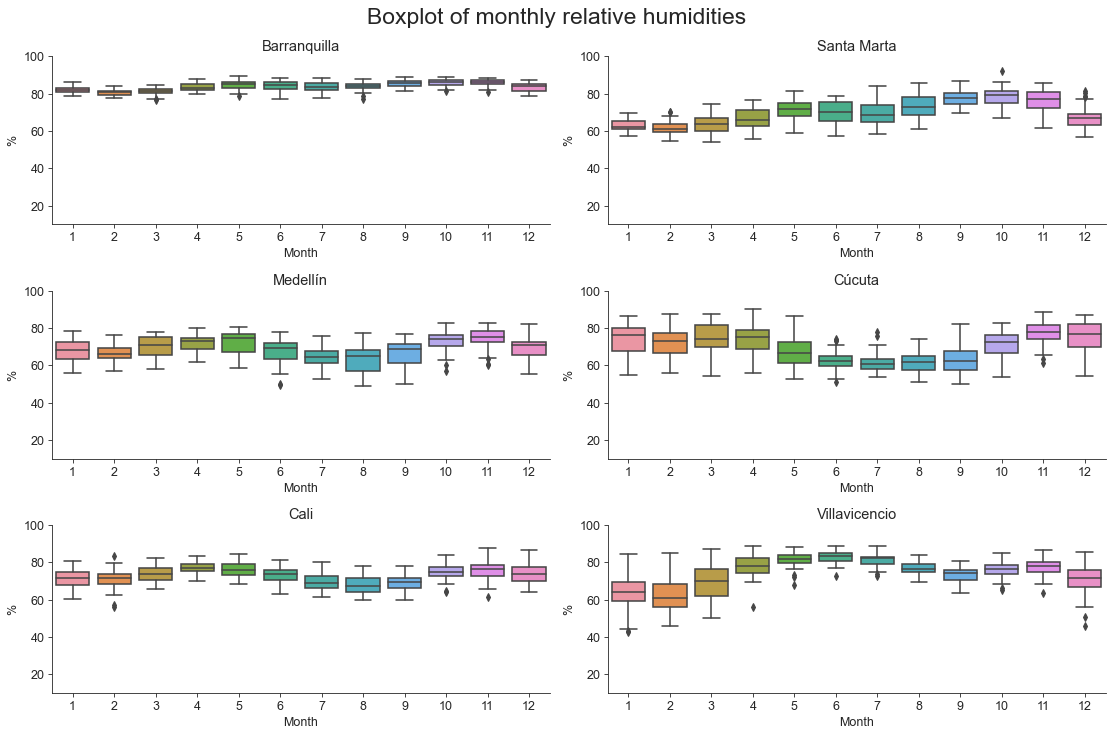

In [282]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]    
    x_array = [df.index.month]
    y_array = [df["REL_HUMIDITY_MEAN"]]
    labels_array = ["Mean relative humidity trend"]
    colors = None
    title = n
    ylabel = "%"
    xlabel = "Month"
    viz.plot_monthly_boxplot(ax[i], x_array, y_array, title, xlabel, ylabel, (10, 100))
    plt.suptitle("Boxplot of monthly relative humidities", fontsize = "22")

fig.tight_layout()
plt.show()

# PRECIPITATION DATA ANALYSIS

The precipitation variable, due to its nature, must be analyzed as the total precipitation. The maximum and minimums in this variable do not describe the general behavior of the variable.

## Cummulative precipitation over the years:

Here we can see the behavior of rain over the years. It is evident that the most rainy city is Villavicencio.

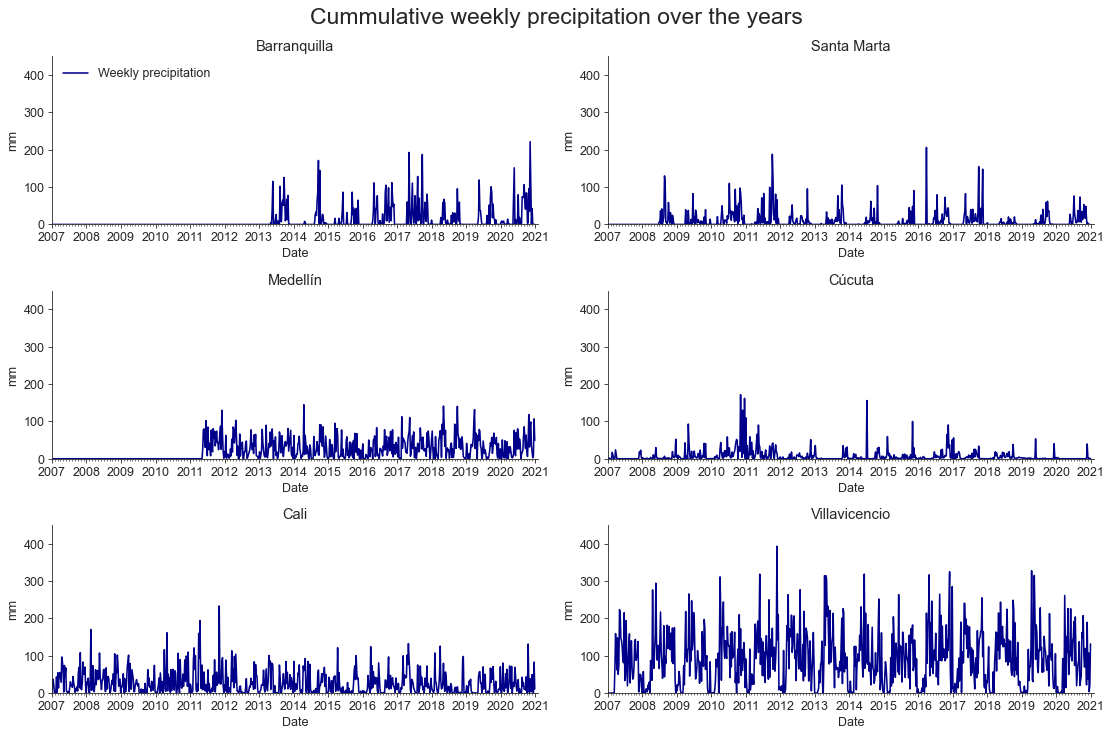

In [302]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["PRECIPITATION"]]
    labels_array = ["Weekly precipitation"]
    title = n
    ylabel = "mm"
    xlabel = "Date"
    colors = ["darkblue"]
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title,  
                     xlabel, ylabel, xlim, (0,450), fulldates = True, area_plot = False)
    plt.suptitle("Cummulative weekly precipitation over the years", fontsize = "22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

## Analysis of precipitation per month

Here we can see the most rainy months for each city. Barranquilla and Santa Marta are the less rainy locations.

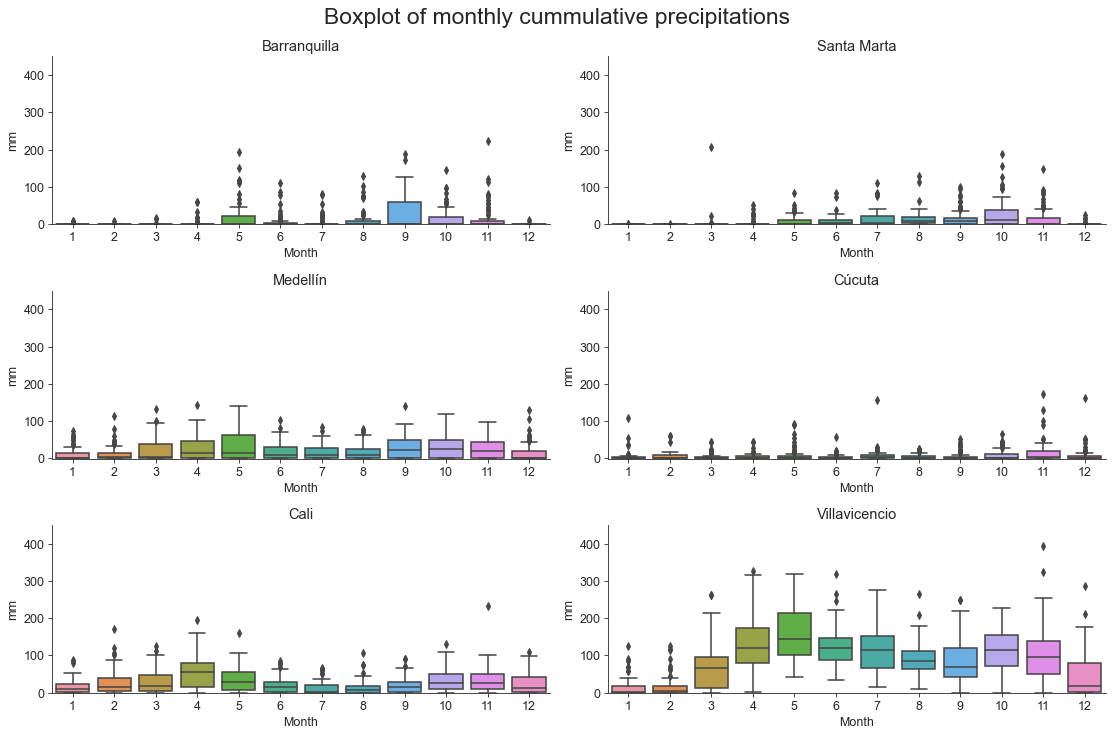

In [284]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]    
    x_array = [df.index.month]
    y_array = [df["PRECIPITATION"]]
    colors = None
    title = n
    ylabel = "mm"
    xlabel = "Month"
    viz.plot_monthly_boxplot(ax[i], x_array, y_array, title, xlabel, ylabel, (-1, 450))
    plt.suptitle("Boxplot of monthly cummulative precipitations", fontsize = "22")
fig.tight_layout()
plt.show()

## Total precipitation and dry days per year

We can analyse the total precipitation and the number of dry days per year. This information confirms what had been seen above.

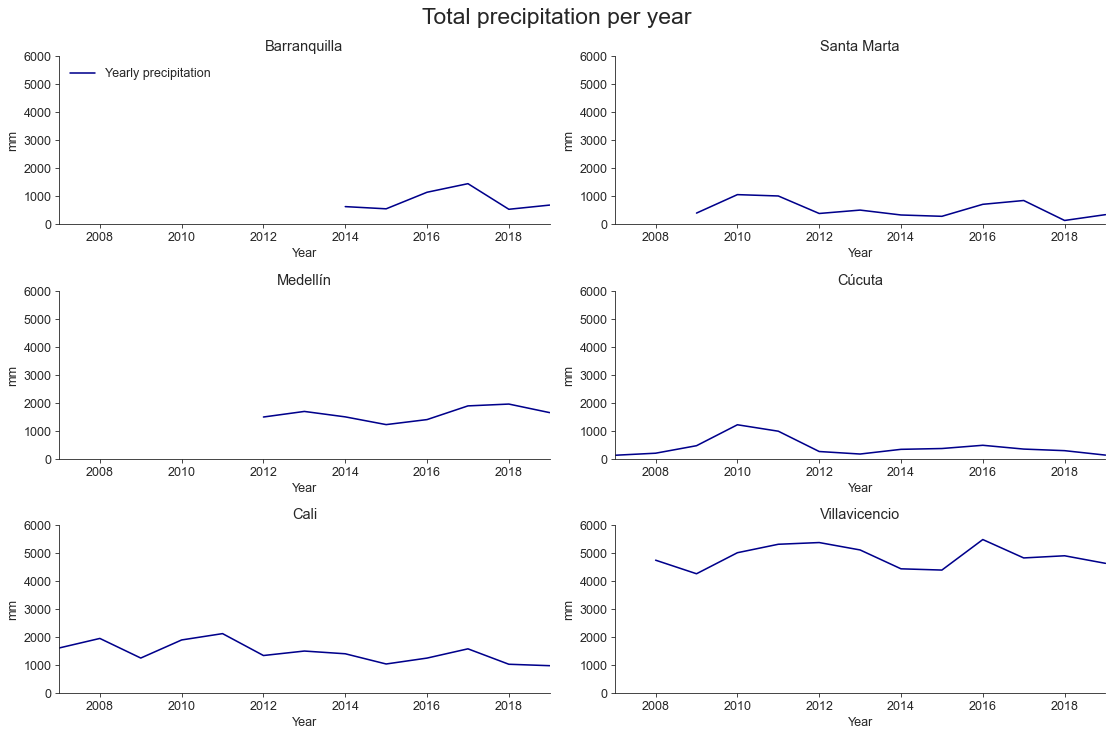

In [303]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    df_prec_yearly = df[(df.index.year >= int(dic_municipios[n]["starting_date"][0:4])+1) & (df.index.year <= 2019)]
    df_prec_yearly = df_prec_yearly[["PRECIPITATION","DRY_DAYS"]]
    df_prec_yearly = df_prec_yearly.groupby(df_prec_yearly.index.year).sum()
    x_array = [df_prec_yearly.index]
    y_array = [df_prec_yearly["PRECIPITATION"]]
    labels_array = ["Yearly precipitation"]
    title = n
    ylabel = "mm"
    xlabel = "Year"
    colors = ["darkblue"]
    xlim = [2007, 2019]
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title,  
                     xlabel, ylabel, xlim, (0, 6000), fulldates = False, area_plot = False)
    plt.suptitle("Total precipitation per year", fontsize = "22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

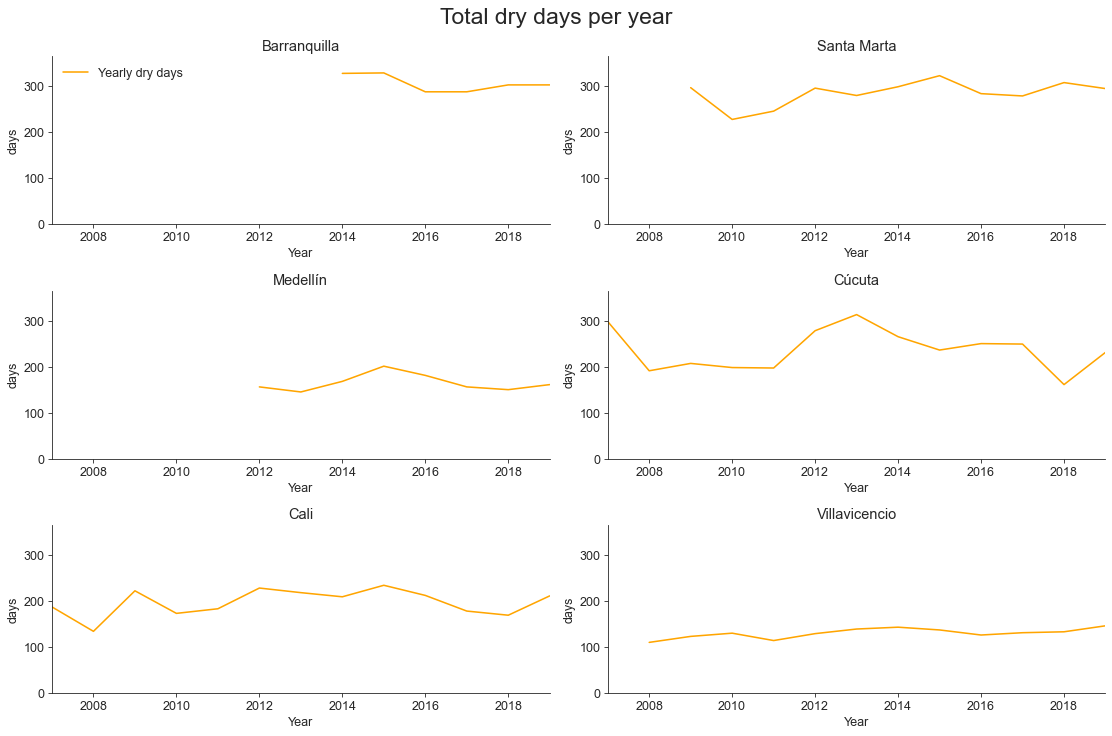

In [304]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    df_prec_yearly = df[(df.index.year >= int(dic_municipios[n]["starting_date"][0:4])+1) & (df.index.year <= 2019)]
    df_prec_yearly = df_prec_yearly[["PRECIPITATION","DRY_DAYS"]]
    df_prec_yearly = df_prec_yearly.groupby(df_prec_yearly.index.year).sum()
    x_array = [df_prec_yearly.index]
    y_array = [df_prec_yearly["DRY_DAYS"]]
    labels_array = ["Yearly dry days"]
    title = n
    ylabel = "days"
    xlabel = "Year"
    colors = ["orange"]
    xlim = [2007, 2019]
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title,  
                     xlabel, ylabel, xlim, (0, 365), fulldates = False, area_plot = False)
    plt.suptitle("Total dry days per year", fontsize = "22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

# EL NIÑO PHENOMENOM DATA ANALYSIS

The Niño indexes are also very important features to analyze in this project. That is why it is interesting to analyze and understand their behavior in time series plots. Most indexes seem to be different enough from each other, except for the Oceanic Niño Index and the Multivariate ENSO Index. In general, negative index or anomaly values indicate a lower than usual temperature, while positive indexes indicate higher than usual temperatures.

## El Niño indexes

Text(0.5, 1.0, 'El Niño phenomenom indexes')

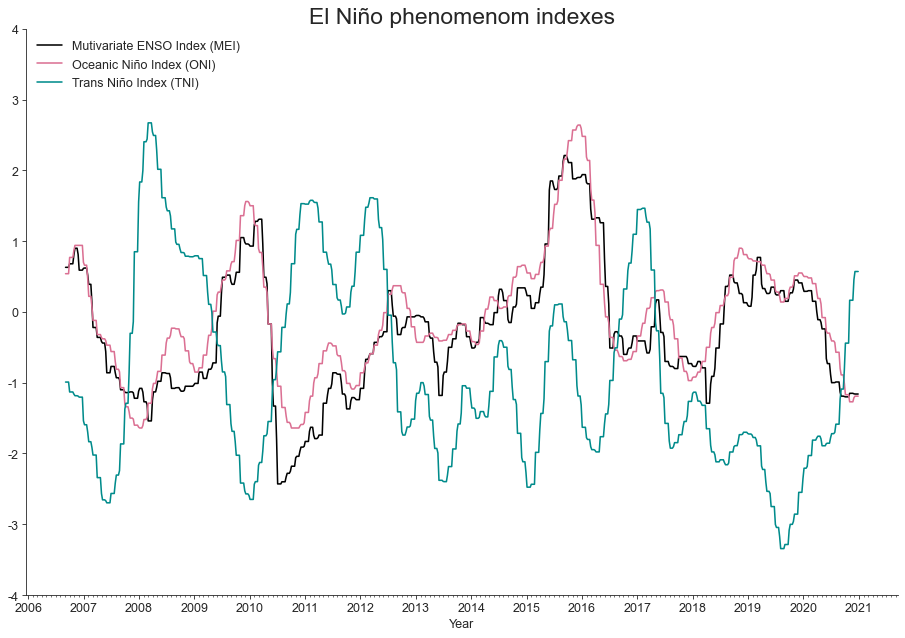

In [387]:
fig, ax = plt.subplots(1,1, figsize=figsize, dpi = dpi)
x_array = [df.index]*3
y_array = [df["MEI"], df["ONI"], df["TNI"]]
labels_array = ["Mutivariate ENSO Index (MEI)", "Oceanic Niño Index (ONI)", "Trans Niño Index (TNI)"]
colors = ["black","palevioletred","darkcyan"]
title = ""
ylabel = ""
xlabel = "Year"
viz.plot_time_series(ax, x_array, y_array, labels_array,colors,title,  xlabel,ylabel, fulldates = True, ylim = [-4,4], area_plot = False)
ax.set_title(label = "El Niño phenomenom indexes", fontsize = "22")

## Sea Surface Temperature variables

It can be seen that the regions closest to Colombia are Niño 1+2 and Niño 3.

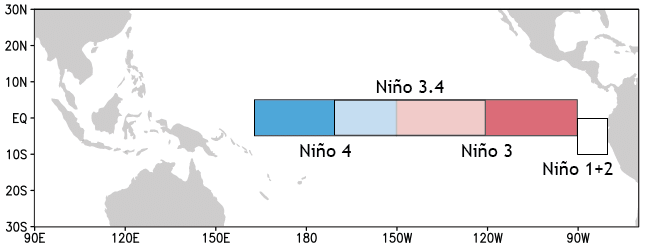

Text(0.5, 1.0, 'Sea Surface Temperature per Niño Region (Pacific)')

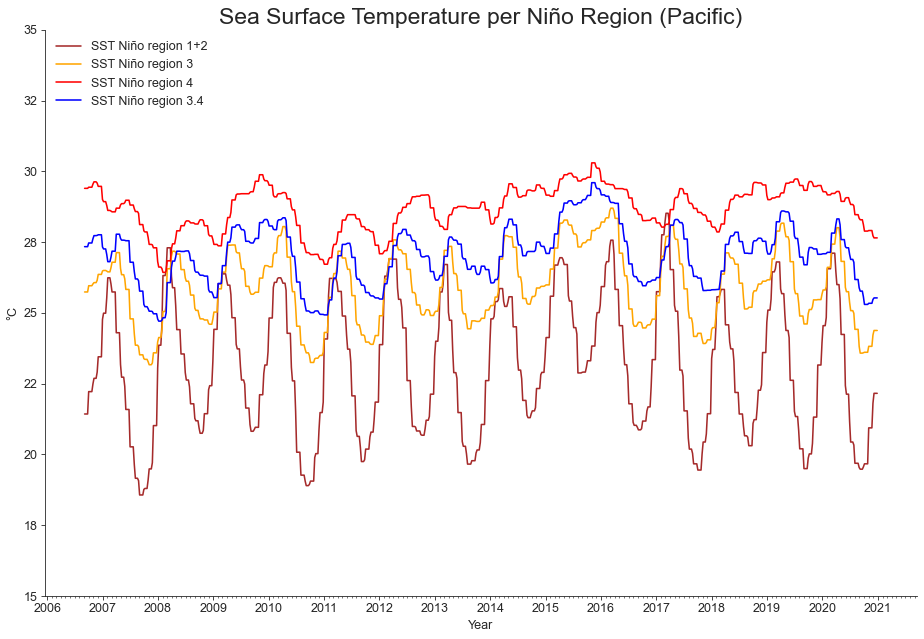

In [310]:
fig, ax = plt.subplots(1,1, figsize=figsize, dpi = dpi)
x_array = [df.index]*4
y_array = [df["SST1+2"], df["SST3"], df["SST4"], df["SST3.4"]]
labels_array = ["SST Niño region 1+2", "SST Niño region 3", "SST Niño region 4", "SST Niño region 3.4"]
colors = ["brown","orange","red","blue"]
title = ""
ylabel = "°C"
xlabel = "Year"
viz.plot_time_series(ax, x_array, y_array, labels_array,colors,title,  xlabel,ylabel, fulldates = True, ylim = [15,35], area_plot = False)
ax.set_title(label = "Sea Surface Temperature per Niño Region (Pacific)", fontsize = "22")

## Sea surface temperature anomalies for the Caribbean and North Atlantic regions

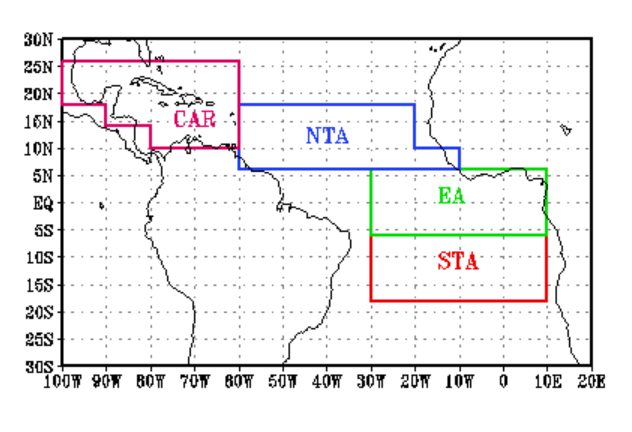

Text(0.5, 1.0, 'Sea Surface Temperature Anomaly for the Caribbean and the North Atlantic Regions')

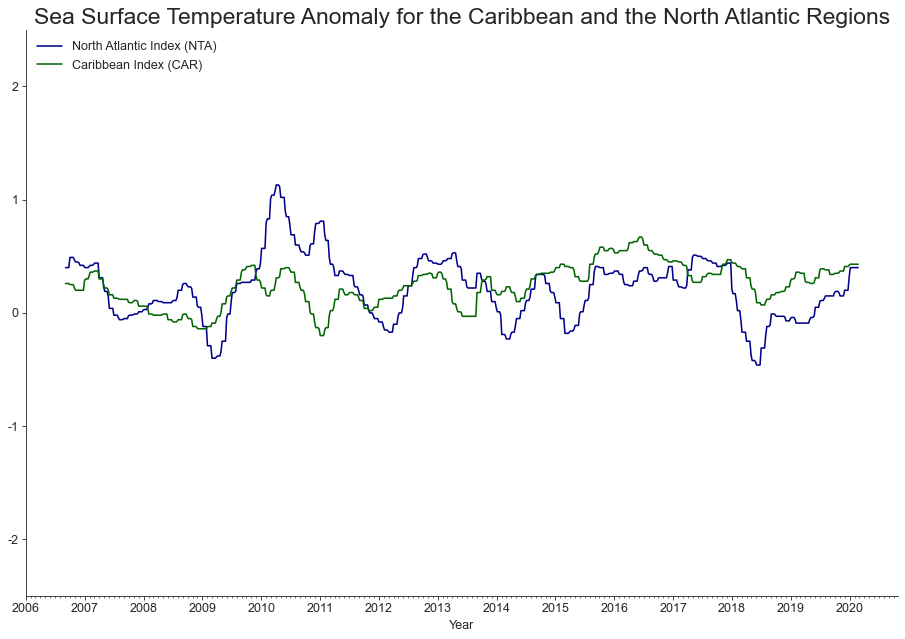

In [307]:
fig, ax = plt.subplots(1,1, figsize=figsize, dpi = dpi)
x_array = [df.index]*2
y_array = [df["NTA"], df["CAR"]]
labels_array = ["North Atlantic Index (NTA)", "Caribbean Index (CAR)"]
colors = ["darkblue","darkgreen"]
title = ""
ylabel = ""
xlabel = "Year"
viz.plot_time_series(ax, x_array, y_array, labels_array,colors,title,  xlabel,ylabel, fulldates = True, ylim = [-2.5,2.5], area_plot = False)
ax.set_title(label = "Sea Surface Temperature Anomaly for the Caribbean and the North Atlantic Regions", fontsize = "22")

# DENGUE DATA ANALYSIS

In these plots we explore the cummulative Dengue cases per week from January 2007 to December 2020 in 6 cities across Colombia. Except for Cali and Barranquilla, a sharp decrease in the number of reported cases can be seen after the arrival date of COVID-19 to Colombia. The arrival date is depicted as a vertical dotted line in each plot. This can be a consequence of the virus overwhelming the health system or of Dengue cases being reported as COVID-19 cases. In either case, this highlights the need for analyzing data up to February 2020.

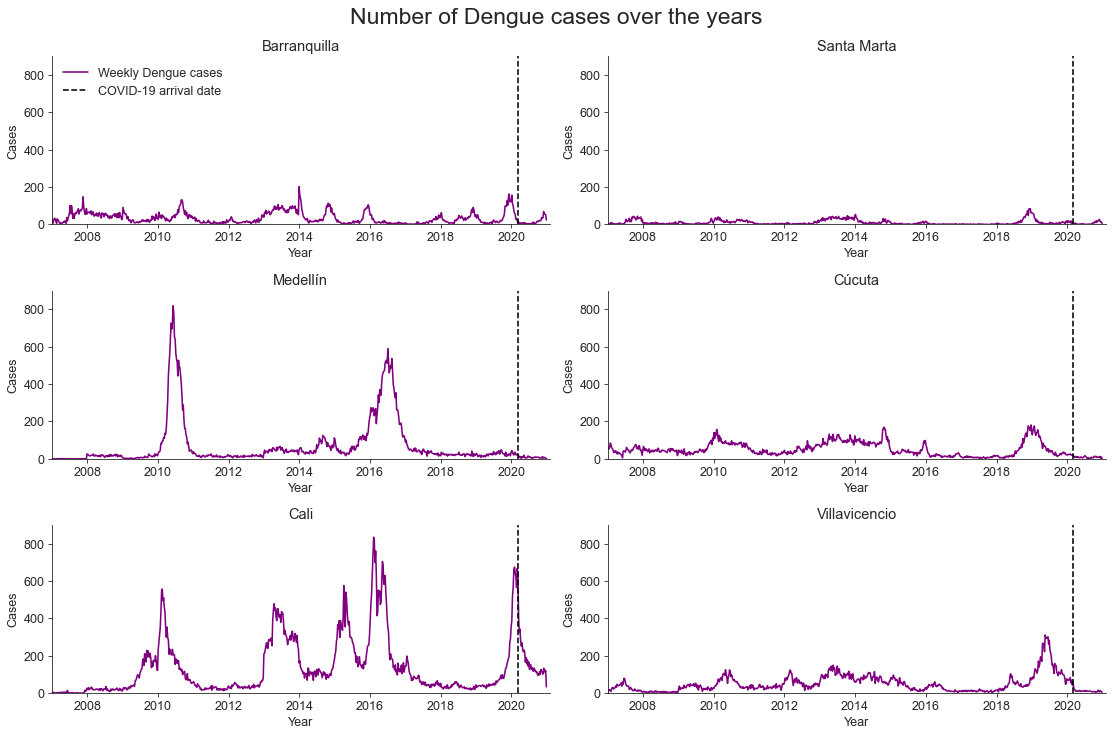

In [308]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["DENGUE"]]
    labels_array = ["Weekly Dengue cases"]
    title =  n
    ylabel = "Cases"
    xlabel = "Year"
    colors = ["purple"]
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel,ylabel, xlim, (0,900), fulldates = False, axvline = pd.to_datetime("2020/03/06"), area_plot = False)
    plt.suptitle("Number of Dengue cases over the years", fontsize="22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

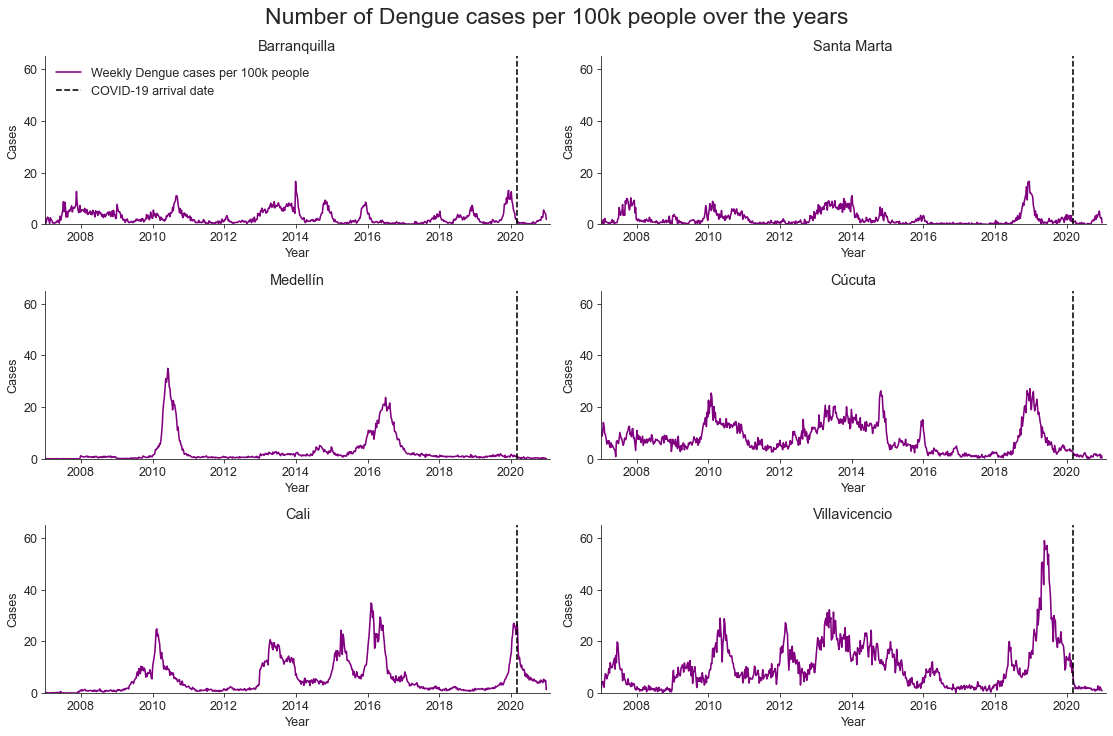

In [309]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["DENGUE_PER_100K"]]
    labels_array = ["Weekly Dengue cases per 100k people"]
    title =  n
    ylabel = "Cases"
    xlabel = "Year"
    colors = ["purple"]
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel,ylabel, xlim, (0,65), fulldates = False, axvline = pd.to_datetime("2020/03/06"), area_plot = False)
    plt.suptitle("Number of Dengue cases per 100k people over the years", fontsize="22")
    if i != 0:
        ax[i].legend().remove()
fig.tight_layout()
plt.show()

# SIMPLE CORRELATION BETWEEN VARIABLES

We review the correlation between variables across the full dataset (all cities) in order to pinpoint variables that are candidates for inmediate removal from the analysis. At this step we only compare variables from the same groups, as their correlation with variables from other groups might be influenced by the number of weeks in between each observation. We can see that minimum and maximum values for temperature and relative humidity are highly correlated with the mean, so we remove them from further analysis. As for the correlation between the Niño index variables, we can see that ONI and MEI are highly correlated, and that there exist other strong correlations. For example, SST4 is highly correlated with the other SST indexes and is thus proposed for removal.

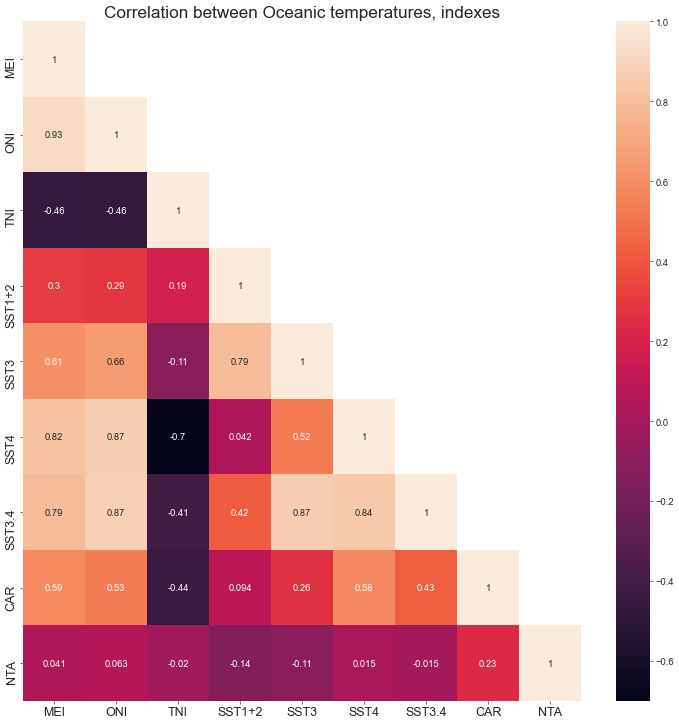

In [271]:
df_for_corr = pd.concat([dic_municipios["Cali"]["df"]])
df_for_corr = df_for_corr[['MEI','ONI',"TNI",'SST1+2', 'SST3', 'SST4', 'SST3.4', "CAR","NTA"]]
fig, axs = plt.subplots(1,figsize=(16,16), dpi = dpi*0.75)
corrMatrix = df_for_corr.corr()
corrMatrix = corrMatrix.where(np.tril(np.ones(corrMatrix.shape)).astype(bool))
g = sns.heatmap(corrMatrix, annot=True)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
plt.title("Correlation between Oceanic temperatures, indexes", fontsize = 22)
plt.show()

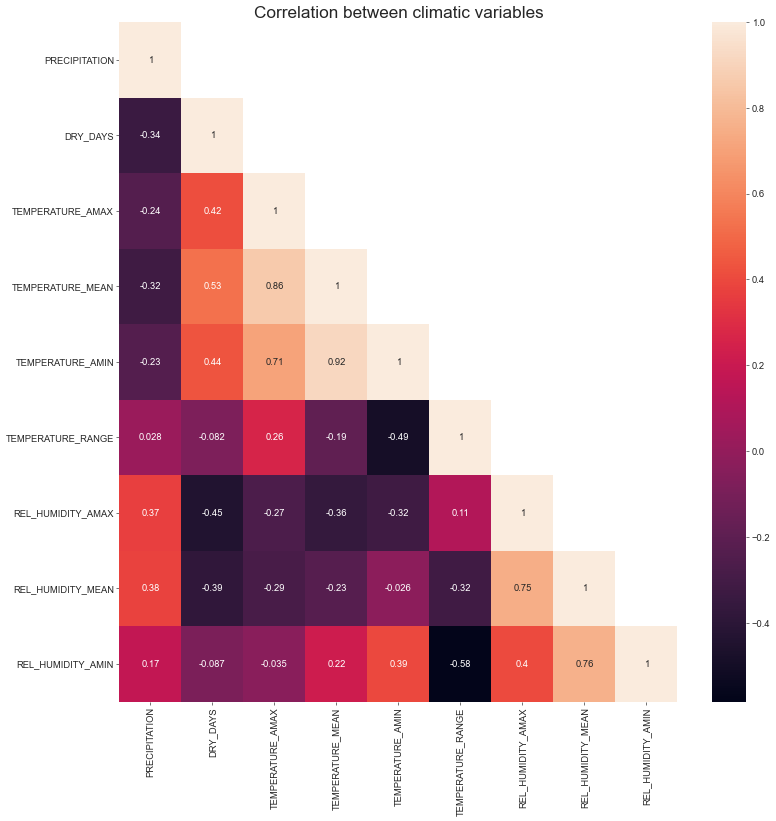

In [272]:
df_for_corr = pd.concat([dic_municipios[n]["df"] for n in municipios])
df_for_corr = df_for_corr[['PRECIPITATION','DRY_DAYS',"TEMPERATURE_AMAX","TEMPERATURE_MEAN", "TEMPERATURE_AMIN","TEMPERATURE_RANGE","REL_HUMIDITY_AMAX","REL_HUMIDITY_MEAN","REL_HUMIDITY_AMIN"]]
fig, axs = plt.subplots(1,figsize=(16,16), dpi = dpi*0.75)
corrMatrix = df_for_corr.corr()
corrMatrix = corrMatrix.where(np.tril(np.ones(corrMatrix.shape)).astype(bool))
sns.heatmap(corrMatrix, annot=True)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 16)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
plt.title("Correlation between climatic variables", fontsize = 22)
plt.show()

# LAGGED CORRELATION ANALYSIS

We must evaluate different lags between the independent variables and the Dengue cases. For this purpose, we will lag all variables to between 4 and 30 weeks. The lower and upper thresholds are defined by the minimum and maximum number of weeks that we want to employ to forecast in future endeavors.

In order to calculate the correlation of dengue with the lagged covariates a function was created. This function guarantees that a correlation is calculated for each meteorological variable for a specific number of lags against dengue (`weeks`). This function lags the meteorological covariate, but does not lag the dengue variable, and according to this data it calculates the respective correlation over time.

Prior to correlation, we normalize the time series by removing the seasonality component from all independent variables.

In [637]:
def plot_all_lagged_correlations(municipios, 
                                 dic_municipios, 
                                 min_lag, 
                                 max_lag, 
                                 cols_to_correlate, 
                                 variable_groups,
                                 label_names,
                                 colors
                                ):
    fig, ax = plt.subplots(len(municipios), len(variable_groups), figsize = (20,12), dpi = dpi*1.5)
    for i,n in enumerate(municipios):
        df_norm, promedios, desv_esta = ts_utils.normalize_timeseries(dic_municipios[n]["df"], 
                                                             mode = "SEASONAL_DECOMPOSE", 
                                                             cols_to_normalize = cols_to_correlate)
        df_corr_melt = pd.melt(df_norm.reset_index().reset_index(), id_vars='index', value_vars=cols_to_correlate)
        df_corr_melt.rename(columns={'index':'lag_size'}, inplace=True)
        df_corr_melt = df_corr_melt[(df_corr_melt["lag_size"]<=max_lag)&(df_corr_melt["lag_size"]>=min_lag)]
        df_corr_melt['corr'] = df_corr_melt.apply(lambda x: lagged_corr(df_norm, x.lag_size, x.variable, 60), axis=1)
        df_corr_melt.columns = ["lag_size","Variable","value","corr"]
        df_corr_pivot = df_corr_melt.pivot_table(columns='lag_size', index='Variable', values='corr')
        dic_municipios[n]["corr"] = df_corr_pivot
        row_max = np.abs(df_corr_pivot).idxmax(axis=1)
        columns = row_max.index
        dic_municipios[n]["best_lags"] = {}
        for j, variable_group in enumerate(variable_groups):
            df_corr_melt_sub = df_corr_melt[df_corr_melt['Variable'].isin((variable_group))]
            for k, var in enumerate(variable_group):
                
                var_df = df_corr_melt_sub[df_corr_melt_sub.Variable==var].copy()
                sns.lineplot(x='lag_size', y='corr', data=var_df, ax = ax[i][j], color = colors[j][k], label = label_names[j][k] )
                
                valid_weeks = var_df["corr"].apply(lambda x: ts_utils.within_maximum_range(x, np.max(np.abs(var_df["corr"].values))))
                var_df = var_df[valid_weeks==True]
                dic_municipios[n]["best_lags"][var] = var_df["lag_size"].values
                ax[i][j].scatter(var_df["lag_size"], var_df["corr"], marker = 'x', s=20, c = colors[j][k])
                
            ax[i][j].set_ylim([-0.65,1])
            ax[i][j].set_xlabel("Lag in weeks with respect to Dengue cases")
            ax[i][j].axhline(y=0, ls='--', label = "", linewidth = 0.5, color = "black")
            ax[i][j].legend(frameon=False)
            if j == 0:
                ax[i][j].set_ylabel("Correlation")
            else:
                ax[i][j].set_ylabel("")

            if j == 1:
                ax[i][j].set_title(" "*73+"Lagged correlation analysis for the "+n + " municipality", fontsize = "18", pad=15)

            if i != 0:
                ax[i][j].legend().remove()
            sns.despine()
    ax[-1][-1].annotate('The x\'s indicate weeks where the correlation\nis maximum or within 2% of the maximum',
                xy=(1, 0.01), xytext=(0, 10),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=10, va='bottom', ha='right')
    plt.tight_layout()
    return dic_municipios

In [739]:
min_lag = 4
max_lag = 24
cols_to_correlate = ['PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_MEAN',
       'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'ONI', 'SST1+2',
       'SST3', 'SST3.4', 'TNI', 'NTA',"CAR","DENGUE_PER_100K"]
variable_groups = [['DENGUE_PER_100K'],
                   ['PRECIPITATION','TEMPERATURE_MEAN','REL_HUMIDITY_MEAN'],
                   ['ONI', 'TNI',"CAR","NTA"], 
                   ["SST1+2","SST3","SST3.4"]]
label_names = [["Dengue cases per\n100k people"], 
               ["Precipitation","Mean temp.","Mean rel. hum."],
               ["Oc. Niño Index (ONI)","Trans Niño Index (TNI)","Caribbean Index (CAR)","North Atlantic Index (NTA)"], 
               ["SST1+2","SST3","SST3.4"]]

colors = [["purple"],
          ["darkblue","red","darkgrey"], 
          ["forestgreen","palevioletred","darkcyan","black"], 
          ["brown","orange","seagreen"]]

## Lagged correlation analysis

For the cities in the Caribbean coast and the south/east of the country, we can see that most variables are correlated to some degree with the number of Dengue cases, but not strongly enough so we can say that they would be strong predictors by themselves. The correlation for all variables is much stronger in Medellín and Cali, which are closer to the Pacific coast. The x's in the lines allow us to see that most variables have strong correlation with lags of between 10 and 20 weeks. The autocorrelation of Dengue is considerable, which is to be expected as a mosquito-transmitted disease, but its behavior in Barranquilla raises some questions.

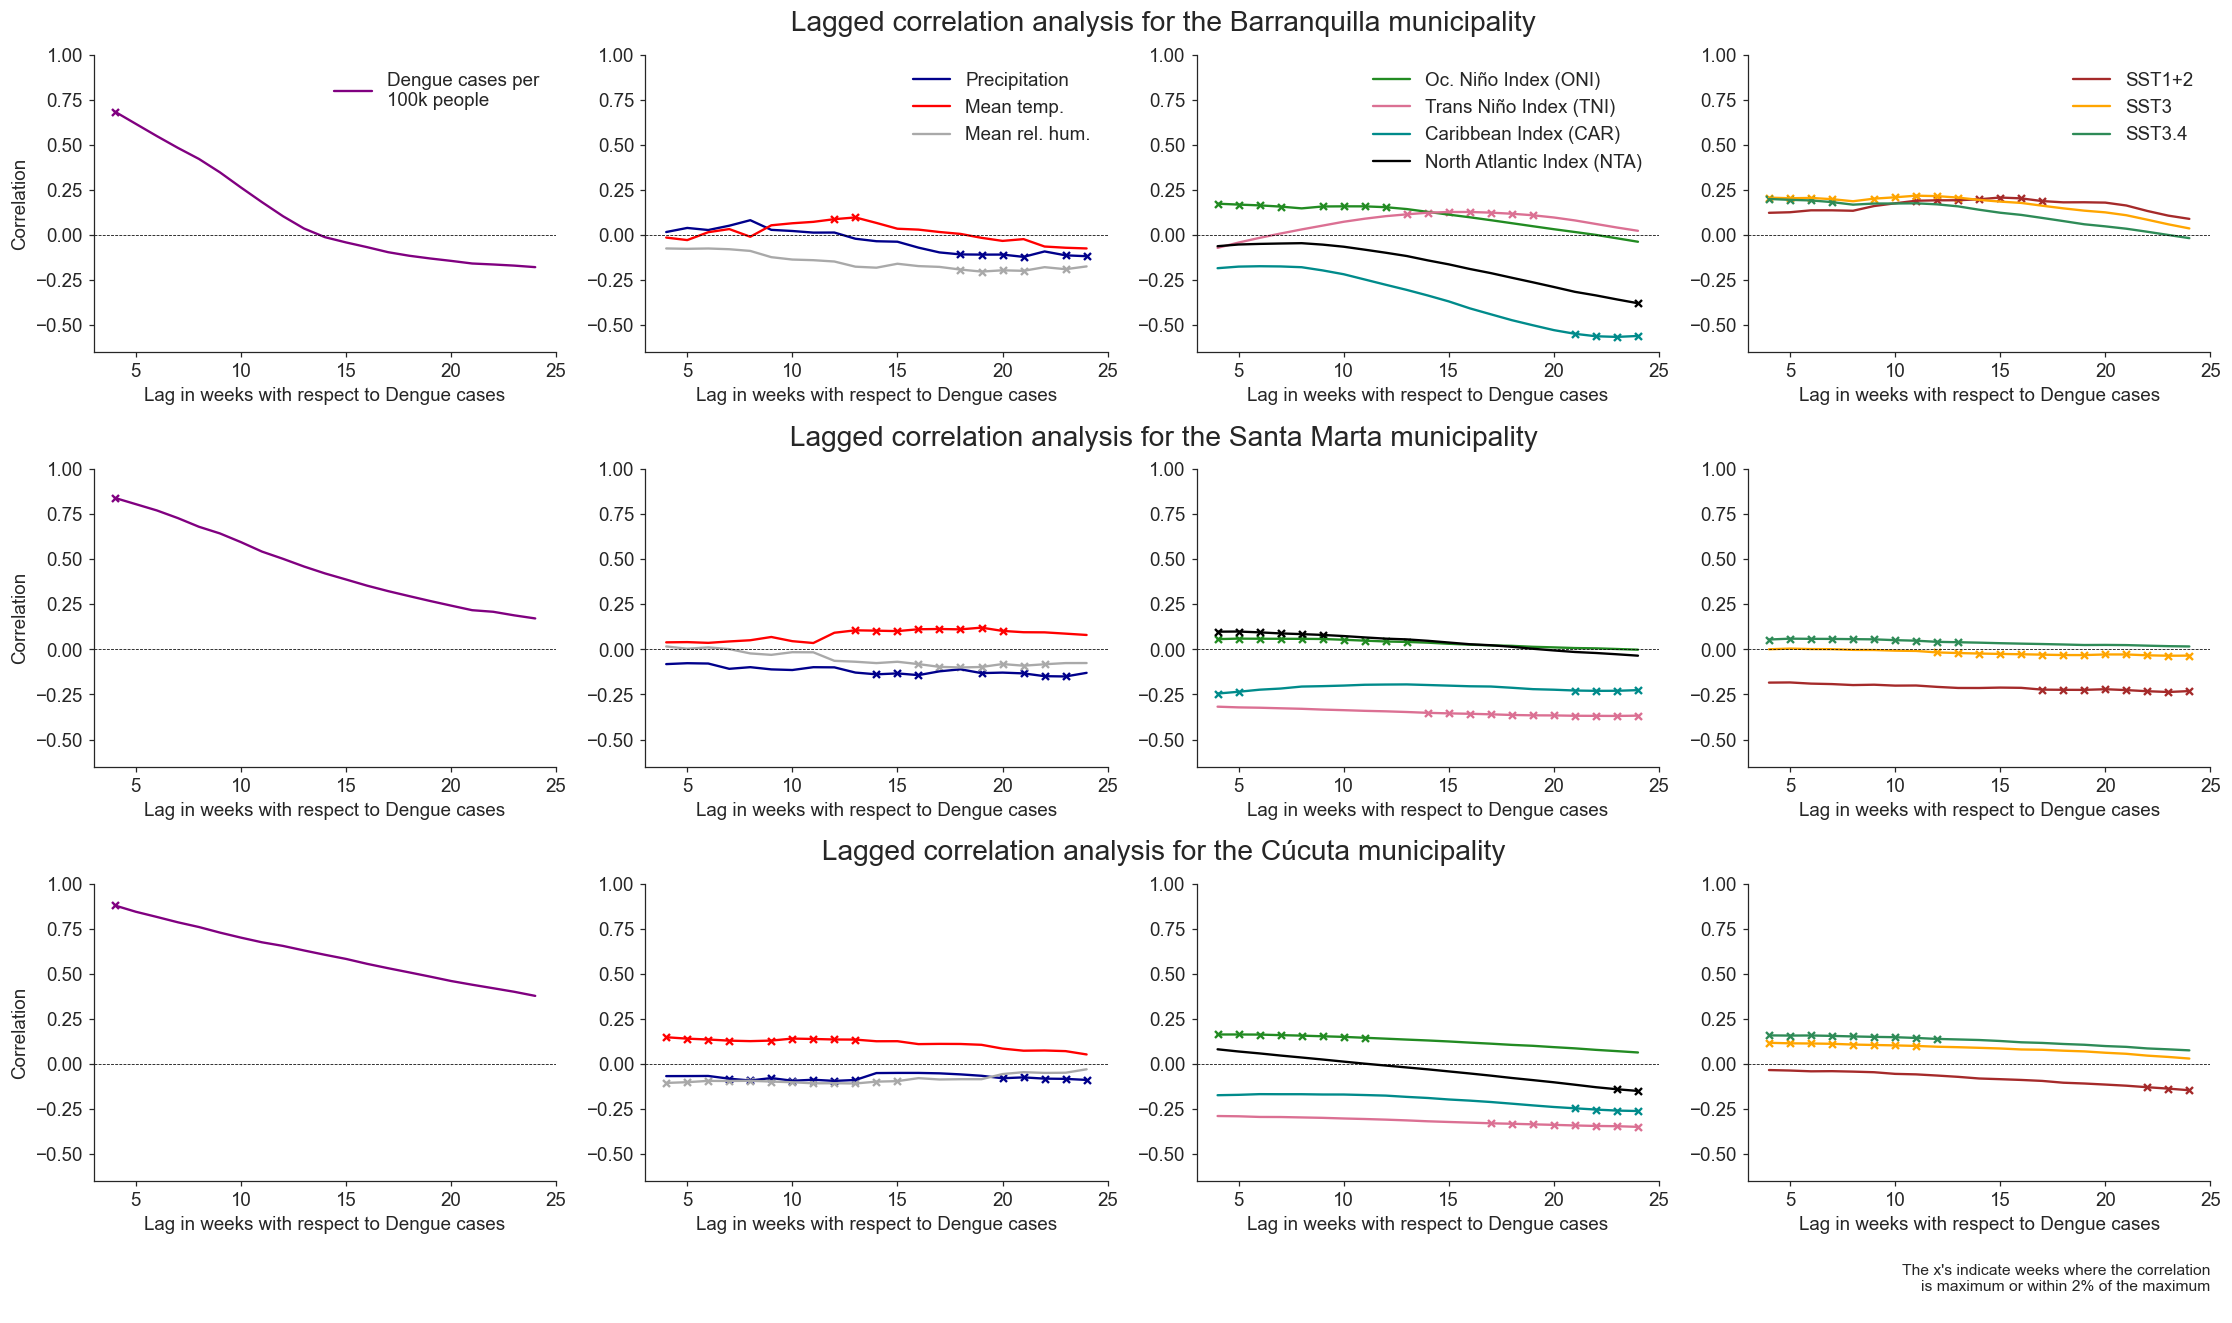

In [757]:
municipios1 = ['Barranquilla', 'Santa Marta', 'Cúcuta']
dic_municipios = plot_all_lagged_correlations(municipios1,dic_municipios,min_lag,max_lag, cols_to_correlate, variable_groups,label_names,colors);

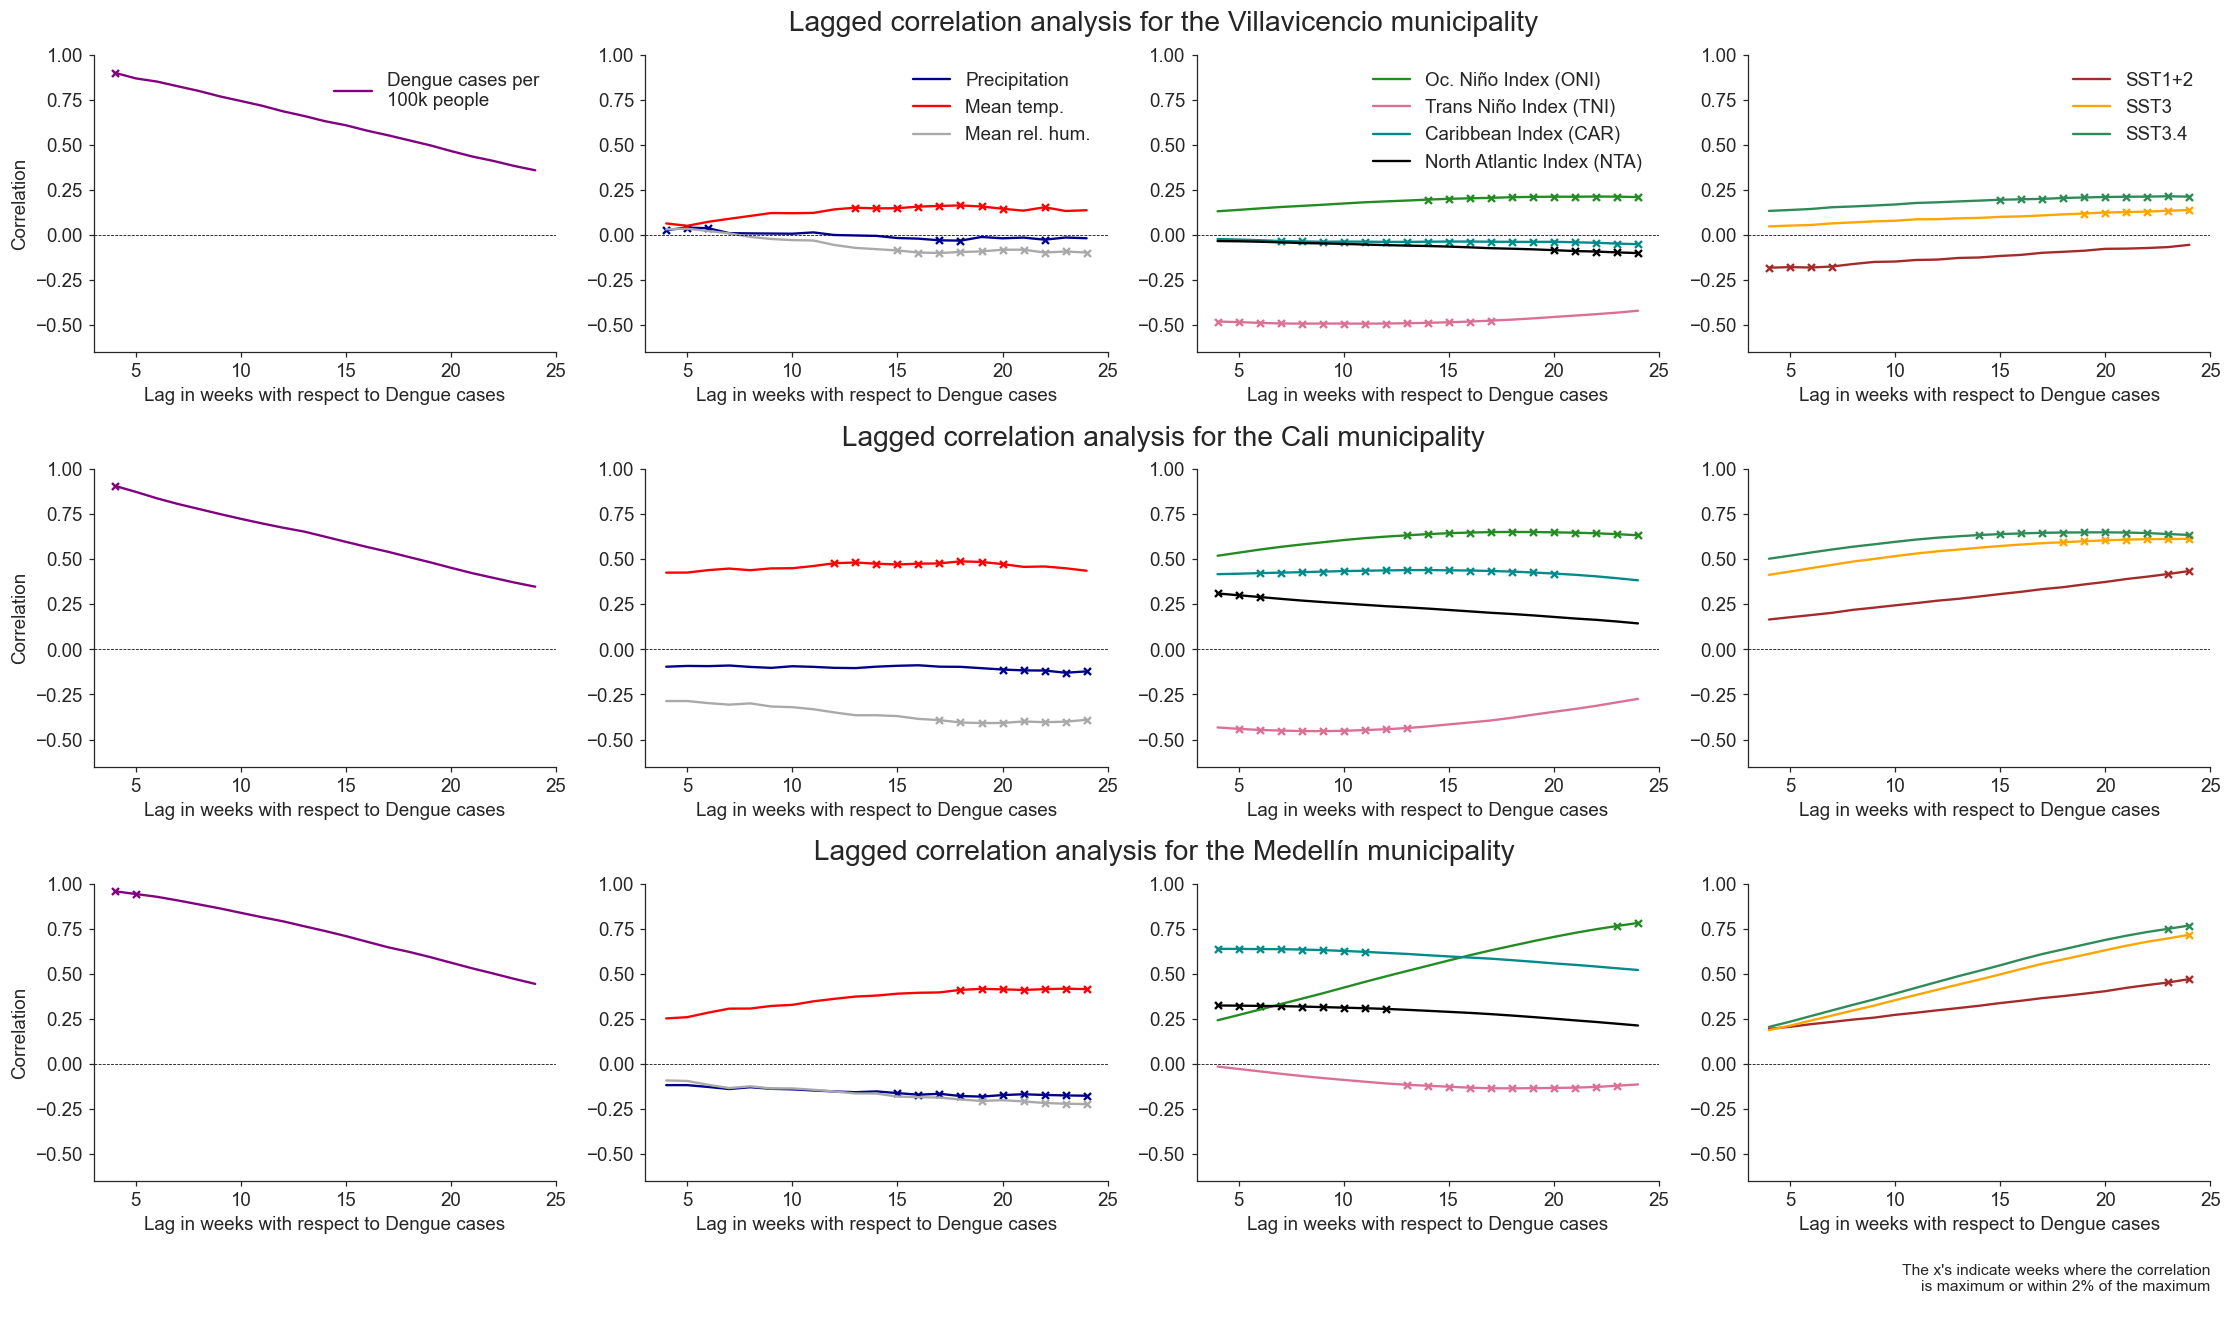

In [758]:
municipios2 = [ 'Villavicencio', 'Cali', 'Medellín']
dic_municipios = plot_all_lagged_correlations(municipios2, 
                                 dic_municipios, 
                                 min_lag, 
                                 max_lag, 
                                 cols_to_correlate, 
                                 variable_groups,
                                 label_names,
                                 colors
                                );

## Determining the best lag per variable and per city for further analyses

In [759]:
dic_best_lags = {"MUNICIPALITY":[]}
dic_best_lags.update({variable:[] for variable in list(dic_municipios[n]["best_lags"].keys())[1:]})
dic_best_lags.update({"Average lag":[]})

In [760]:
for n in dic_municipios.keys():
    dic_best_lags["MUNICIPALITY"].append(n)
    all_lags = []
    for variable in list(dic_municipios[n]["best_lags"].keys())[1:]:
        #print((variable.replace("_"," ").title() if len(vint(np.median(dic_municipios[n]["best_lags"][variable]))ariable) > 7 else variable)+": ", end = "")
        lag = int(np.median(dic_municipios[n]["best_lags"][variable]))
        dic_best_lags[variable].append(lag)
        all_lags.append(lag)
    dic_best_lags["Average lag"].append(int(np.mean(all_lags)))

In [761]:
df_best_lags = pd.DataFrame.from_dict(dic_best_lags)
df_best_lags.columns = ["Municipality","Precipitation","Mean temp.","Mean r. hum.","ONI","TNI","CAR","NTA","SST1+2","SST3","SST3.4","Average lag"]

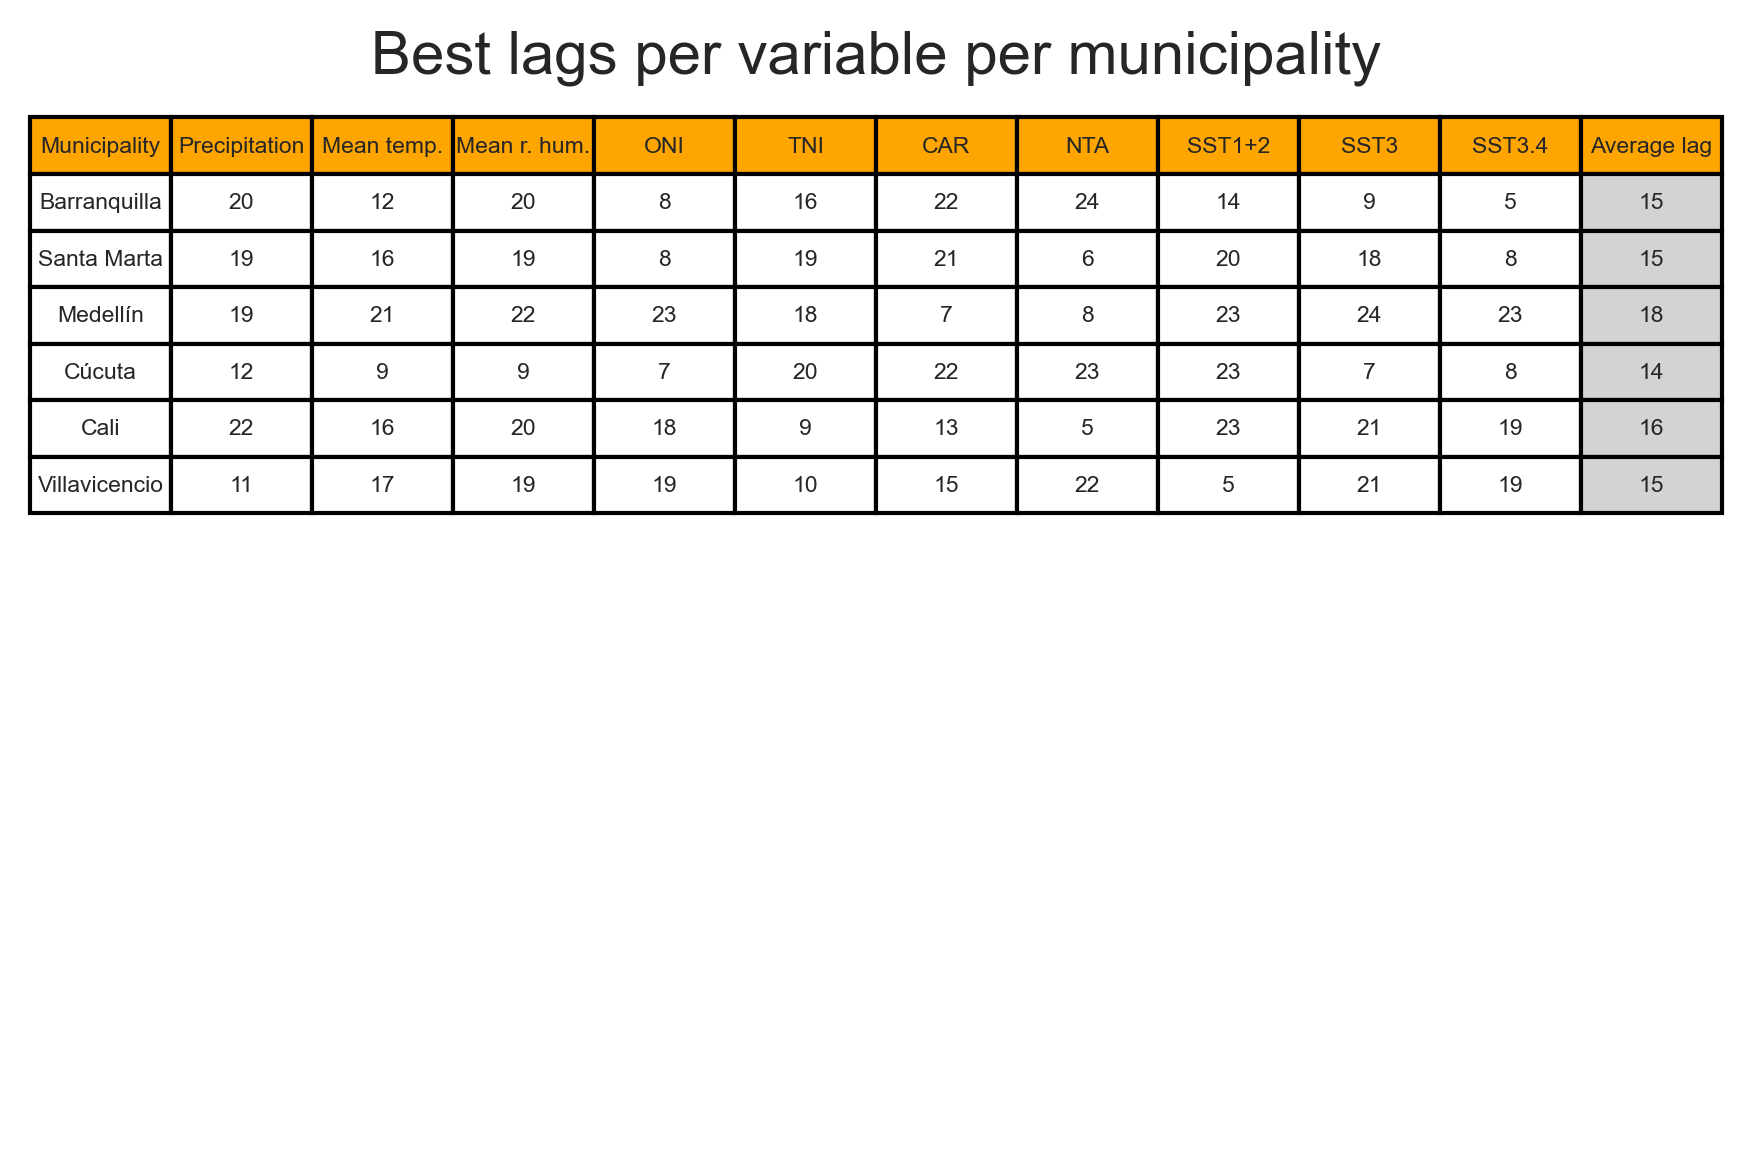

In [774]:
fig = plt.figure(dpi=300)
plt.axis('off')
table  = plt.table(cellText=df_best_lags.values,
          colLabels=df_best_lags.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='upper center')
for i in range(0,12):
    table[(0, i)].set_facecolor("orange")
#for i in range(1, 7):
#    table[(i, 0)].set_facecolor("lightgray")
for i in range(1, 7):
    table[(i, 11)].set_facecolor("lightgray")
plt.title("Best lags per variable per municipality")
table.auto_set_font_size(False)
table.set_fontsize(5.5)

plt.tight_layout()

# GROUPED SCATTERPLOTS

At this point, we are interested in determining how the more relevant climate variables correlate with Dengue for each city. Since we have so many data points we decide to consolidate all variables as yearly averages/sums on a city basis. We choose the average lag of 16 as per the previous table.

In [793]:
def get_lagged_df(df, weeks):
    columns_to_lag = df.columns[5:-2]
    lagged_columns = df[columns_to_lag].shift(periods=weeks).iloc[weeks:]
    new_df = df.copy().iloc[weeks:]
    new_df[columns_to_lag] = lagged_columns
    return new_df
avg_lags = 16
for n in dic_municipios.keys():
    dic_municipios[n]["df_lagged"] = get_lagged_df(dic_municipios[n]["df"], avg_lags).dropna()


## Yearly scatterplot

In this plot we can see how the climate variables impact the Dengue cases per year. Hotter years tend to have more Dengue cases, while humid years tend to have less Dengue cases. 

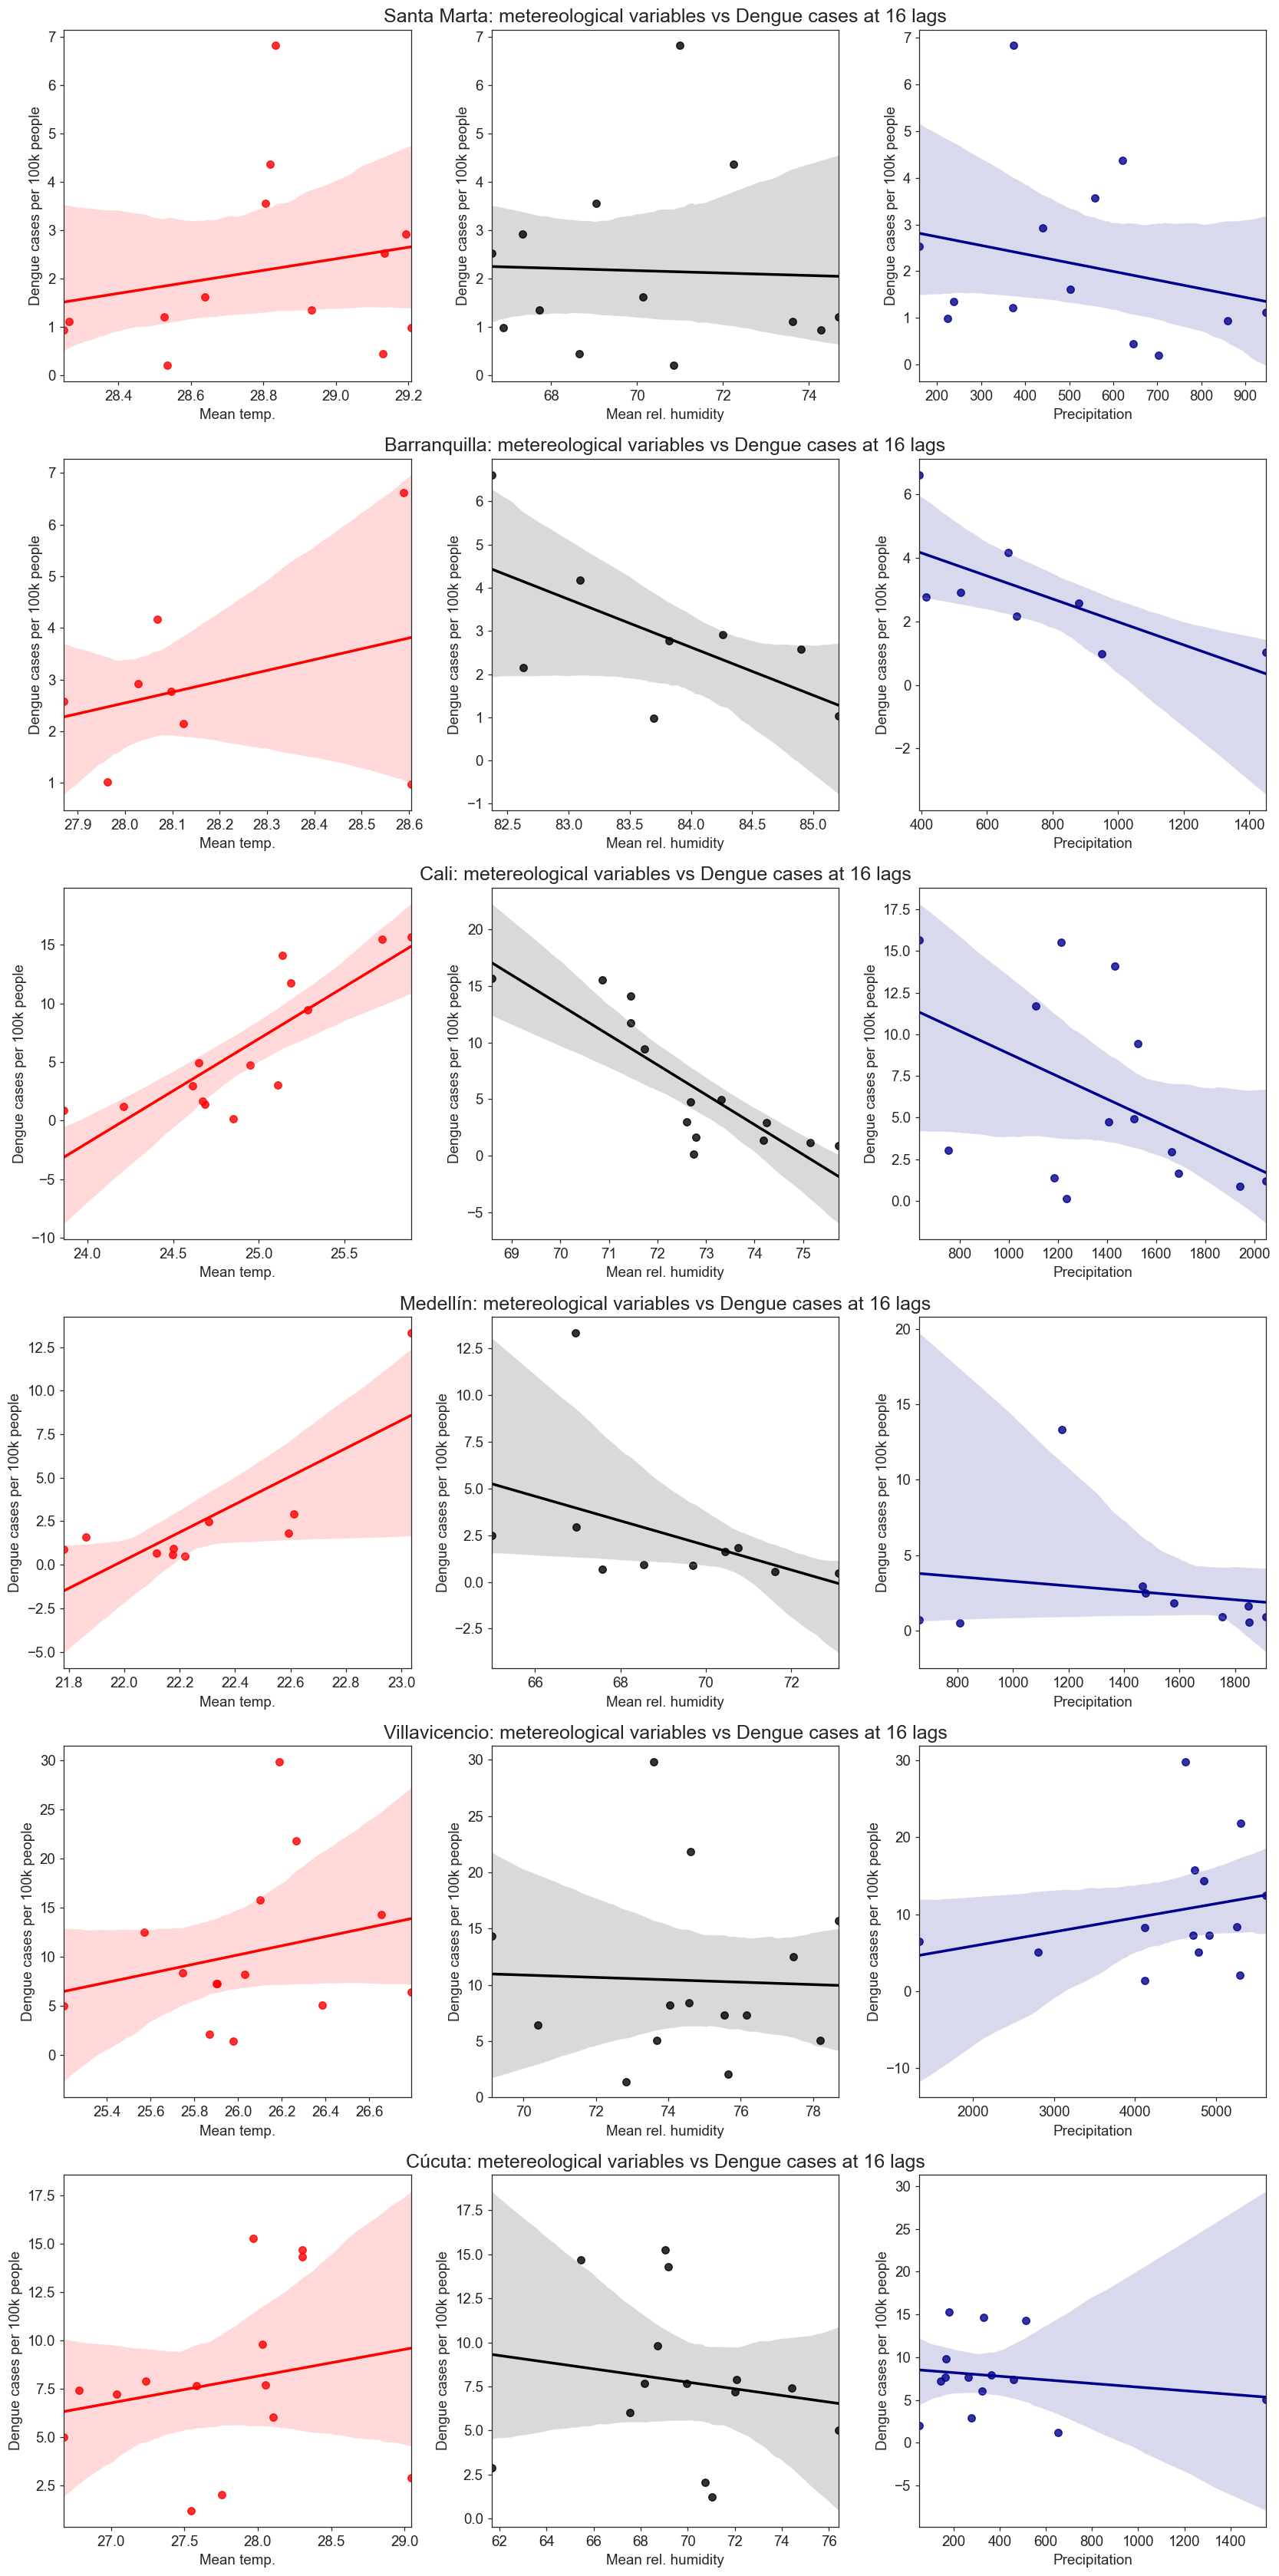

In [795]:

fig, ax = plt.subplots(6,3, figsize=(15,30), dpi = dpi*1.5)
#ax = ax.flatten()
variables = ["TEMPERATURE_MEAN","REL_HUMIDITY_MEAN","PRECIPITATION"]#, "ONI","SST1+2","CAR"]
variable_names = ["Mean temp.", "Mean rel. humidity", "Precipitation"]#, "Oceanic Niño Index", "SST1+2", "Caribbean Index"]
colors = ["red","black","darkblue"]

cities = ["Santa Marta", "Barranquilla","Cali","Medellín","Villavicencio","Cúcuta"]
#cities = ["Santa Marta", "Barranquilla","Cali","Medellín""Villavicencio","Cúcuta"]
for k, group in enumerate(cities):
    for i, var in enumerate(variables):

        df_yearly = pd.concat([dic_municipios[n]["df_lagged"] for n in municipios]).dropna()
        df_yearly = df_yearly[df_yearly["CITY"]==group]
        grouper = "ANO"
        df_yearly_means = df_yearly[["ANO","SEMANA","TEMPERATURE_MEAN","TEMPERATURE_RANGE","REL_HUMIDITY_MEAN", 'MEI','ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'CAR','NTA', 'DENGUE_PER_100K']].groupby([grouper]).mean().reset_index()
        df_yearly_sums = df_yearly[["ANO", 'SEMANA', 'PRECIPITATION','DRY_DAYS', 'DENGUE']].groupby([grouper]).sum().reset_index()
        df_yearly = pd.merge(df_yearly_means,df_yearly_sums, how = "left", on = [grouper] )

        palette = sns.color_palette("colorblind")
        sns.set_palette(palette)
        sns.regplot(x = df_yearly[var], y = df_yearly["DENGUE_PER_100K"], ax = ax[k][i], color = colors[i])
        ax[k][i].set_xlabel(variable_names[i])
        ax[k][i].set_ylabel("Dengue cases per 100k people")
        if i == 1:
            ax[k][i].set_title(cities[k]+f": metereological variables vs Dengue cases at {avg_lags} lags", fontsize = "16")
        #plt.suptitle("Climatic variables vs Dengue cases per year", fontsize="22")
plt.tight_layout()

# Yearly Dengue cases vs oceanic indexes and temperatures

In general, the Dengue cases seem to be much more correlated with the Oceanic and Niño index variables in the Pacific region, when compared to the other two regions.

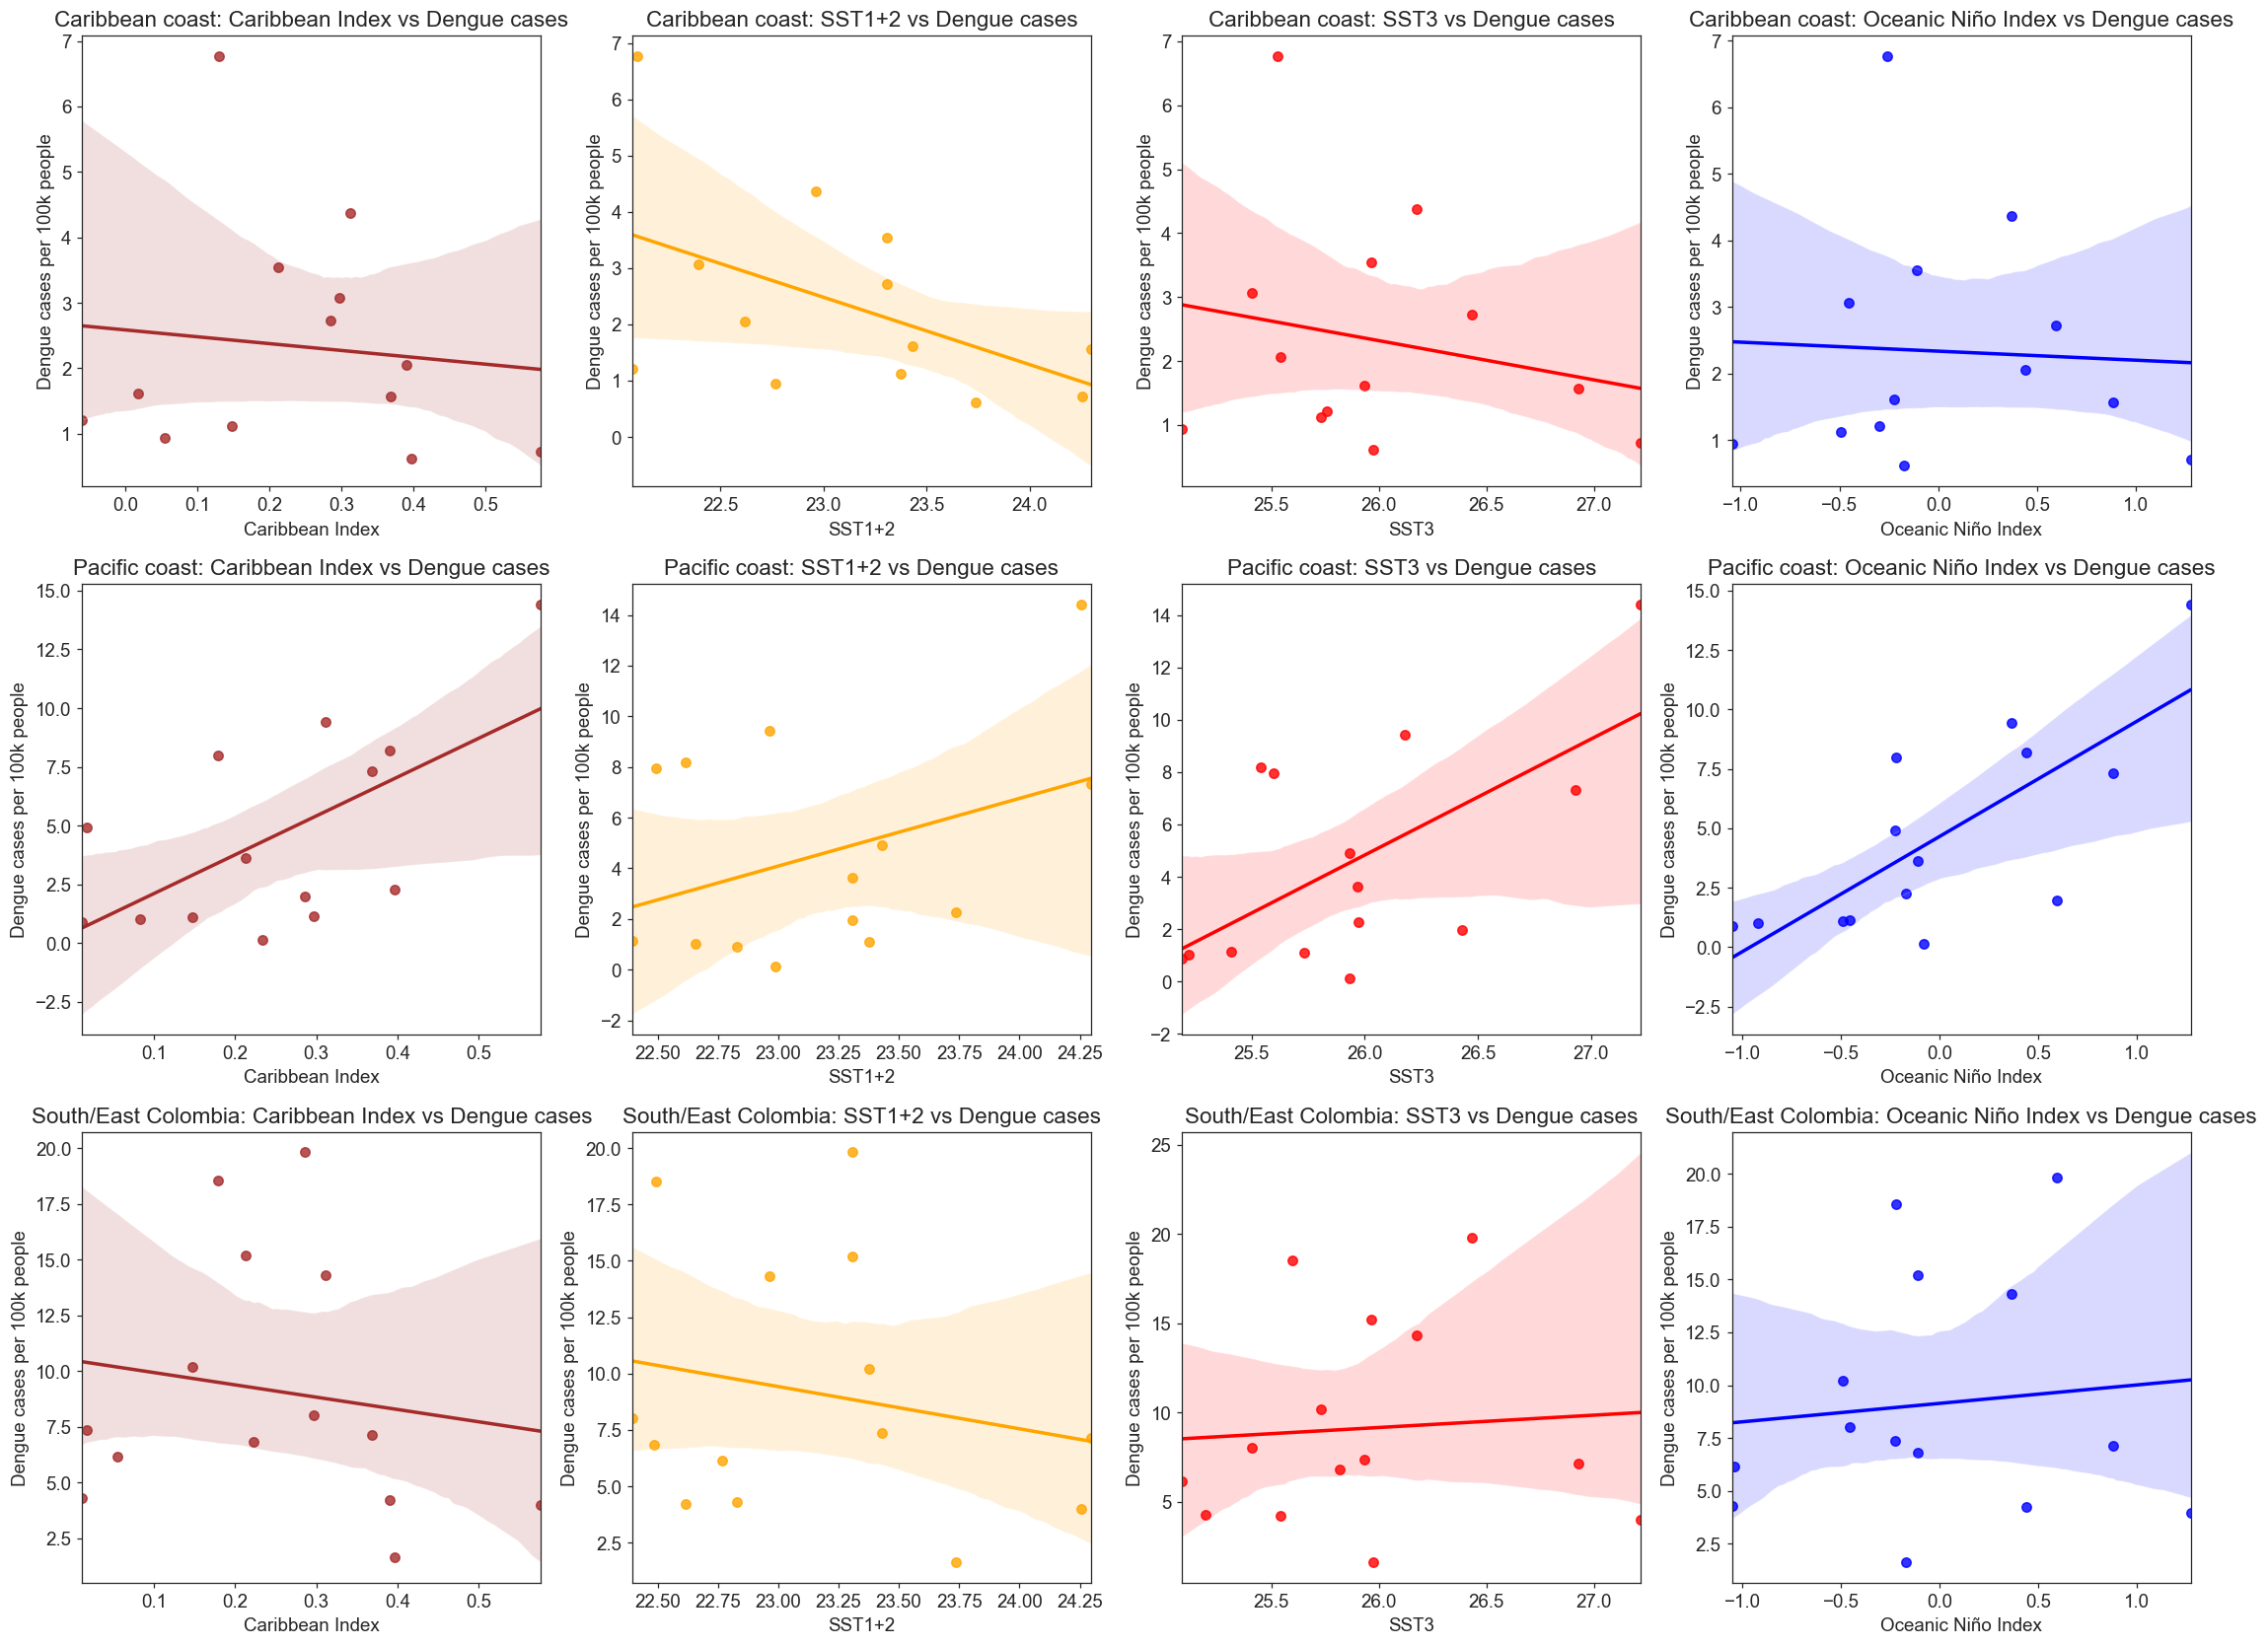

In [796]:

fig, ax = plt.subplots(3,4, figsize=(20,15), dpi = dpi*1.5)
#ax = ax.flatten()
variables = ["CAR","SST1+2","SST3","ONI"]#, "ONI","SST1+2","CAR"]
variable_names = ["Caribbean Index", "SST1+2","SST3", "Oceanic Niño Index"]#, "Oceanic Niño Index", "SST1+2", "Caribbean Index"]
colors = ["brown","orange","red","blue"]

groups = ["Caribbean coast", "Pacific coast", "South/East Colombia"]
group_members = [["Santa Marta", "Barranquilla"],["Cali","Medellín"],["Villavicencio","Cúcuta"]]

for k, group in enumerate(groups):
    for i, var in enumerate(variables):

        df_yearly = pd.concat([dic_municipios[n]["df_lagged"] for n in municipios]).dropna()
        df_yearly = df_yearly[df_yearly["CITY"].isin(group_members[k])]
        grouper = "ANO"
        df_yearly_means = df_yearly[["ANO","SEMANA","TEMPERATURE_MEAN","TEMPERATURE_RANGE","REL_HUMIDITY_MEAN", 'MEI','ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'CAR','NTA', 'DENGUE_PER_100K']].groupby([grouper]).mean().reset_index()
        df_yearly_sums = df_yearly[["ANO", 'SEMANA', 'PRECIPITATION','DRY_DAYS', 'DENGUE']].groupby([grouper]).sum().reset_index()
        df_yearly = pd.merge(df_yearly_means,df_yearly_sums, how = "left", on = [grouper] )

        palette = sns.color_palette("colorblind")
        sns.set_palette(palette)
        sns.regplot(x = df_yearly[var], y = df_yearly["DENGUE_PER_100K"], ax = ax[k][i], color = colors[i])
        ax[k][i].set_xlabel(variable_names[i])
        ax[k][i].set_ylabel("Dengue cases per 100k people")
        ax[k][i].set_title(groups[k]+": "+variable_names[i]+" vs Dengue cases")
        #plt.suptitle("Climatic variables vs Dengue cases per year", fontsize="22")
plt.tight_layout()

# Future work:

- In general, this exercise allowed us to examine the relationships between all variables and identify the most important ones for further review.

- We believe that the scatterplots could be improved by:

    1. Disaggregating the yearly metereological variables scatterplot into regions or cities.
    2. Calculating the average of the absolute values of the slopes for each region in the second set of scatterplots to quantify the impact of all variables.